# Imports

In [1]:
# %pip install -U dataprep --user

In [2]:
# работа с даными
import numpy as np
import pandas as pd
import itertools

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt

#разведка данных
from dataprep import eda

# валидация и метрики
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

# препроцессинг
from sklearn.preprocessing import StandardScaler

# алгоритмы ML
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# от ворнингов
import warnings
warnings.simplefilter("ignore")

# фиксируем рандом
random_seed = 142

# Описание функций

In [3]:
def col_by_bins(df, cols, p):
    "Функция разделения числовых и категориальных признаков на корзины с количеством значений не менее доли p."
    "Функция возвращает обновлённый датасет df и список с названием новых колонок"
    bins_cols = []
   
    for col in cols:

        data_type = df[col].apply(type).mode()[0]
        if data_type == float or data_type == int:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna('isNaN')      
        
        bins_cols.append(col + '_bins' + str(p).replace('.', ''))

        bin_data = df[col].value_counts().sort_index()
        keys = []
        values = []

        k = 1
        i = 0

        while True:
            sums = bin_data.iloc[i:i+k].sum()
            if sums > df.shape[0] * p:
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                i = k + i
                k = 1
            else:
                k += 1
                
            if i + k > len(bin_data):
                keys.append(np.array(bin_data.index[i: i+k]))
                values.append(sums)
                break

        for i, key in enumerate(keys):
            df.loc[df[col].isin(key), col + '_bins' + str(p).replace('.', '')] = i

    df[bins_cols] = df[bins_cols].astype(float)
    return df, bins_cols

def hist_log_compare (df, cols):
  "Функция вывода распредения признака и распределения логарифмированного признака на логарифмированной сетке"
  for col in cols:       
        
        fig, axs = plt.subplots(1, 2, figsize=(25, 5))

        if df[col].nunique() > 100:
            n_bins = 100
        else:
            n_bins = df[col].nunique()

        width_1 = abs(df[col].max() - df[col].min()) / 100
        width_2 = abs(np.log(df[col]+1).max() - np.log(df[col]+1).min()) / 100

        axs[0].hist(df[col], bins = n_bins, width=width_1)
        title_0 = 'Базовое распределение '+col
        axs[0].set_title(title_0)
        axs[0].set_yscale('log')
        
        axs[1].hist(np.log(df[col]+1), bins = n_bins, width=width_2)
        title_1 = 'Логарифмированное распределение '+col
        axs[1].set_yscale('log')
        axs[1].set_title(title_1)

        plt.show()
        print ()

def order_values (df, cols, target, prefix = ''):
    "Функция упорядочивания значений признака по среднему значению таргета каждого значения"
    temp = df.copy()
    for col in cols:
        values = df.groupby(col).mean()[target].sort_values()
        for i in range(len(values)):
            temp.loc[df[col] == values.index[i], col] = i
        df[col + prefix]  = temp[col]    
    return df

# функция взята с https://www.machinelearningmastery.ru/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04/
def calculate_woe_iv(dataset, feature, target):
    "Функция расчёта Weight of evidence и Information Value"
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = -np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * (-dset['WoE'])
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='Value')
    return dset, iv

def print_barhs (df, cols, target):
    "Функция вывода вертикальных столбцов со значениями"
    "Value_counts, Information Value, Shift of target, Weight of Evidence"
    mean_target = df[target].mean()

    for col in cols:
        
        data, iv = calculate_woe_iv(df, col, target)
        
        print()
        print(col, ' ', 'IV score: {:.4f}'.format(iv))
        print()
        x = (df.groupby(col).mean()[target] - mean_target).sort_index().index.to_list()
        y1 = df[col].value_counts().sort_index().values
        y2 = data.sort_values(by = 'Value')['IV']
        y3 = ((df.groupby(col).mean()[target] - mean_target) * df[col].value_counts() / df.shape[0]).sort_index().values
        y4 = data.sort_values(by = 'Value')['WoE']
        

        fig, axs = plt.subplots(1, 4, figsize=(25, 5))

        axs[0].barh(x, y1, height=0.5)
        axs[0].set_title('Value_counts')
        axs[1].barh(x, y2, height=0.5)
        axs[1].set_title('Information value')
        axs[2].barh(x, y3, height=0.5)
        axs[2].set_title('Shift of target')
        axs[3].barh(x, y4, height=0.5)
        axs[3].set_title('Weight of evidence')

        plt.show()
        print()

def cl_fs(
    cl, cl_helper, X_train, y_train, fs_indices, 
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    """ Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации """

    temp_features = features
    new_feats = []

    for p in ps:

        cl_helper.fit(X_train.loc[fs_indices, temp_features], y_train.loc[fs_indices])

        imp = pd.Series(data = cl_helper.feature_importances_, index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

def L1_fs (
    cl, cl_helper, X_train, y_train, fs_indices,
    step, ps, features, cv, table_train, 
    table_test, metric, name
    ):
    "Итеративный отбор доли лучших признаков и проверка метрики на кросс-валидации"
    temp_features = features
    new_feats = []

    scl = StandardScaler()
    X_train_std = pd.DataFrame(
        data = scl.fit_transform(X_train[features]), 
        columns=features,
        index = X_train.index
        )

    for p in ps:

        cl_helper.fit(X_train_std.loc[fs_indices, temp_features], y_train.loc[fs_indices])

        imp = pd.Series(data = np.abs(cl_helper.coef_[0]), index = temp_features)

        number_of_feats = len(temp_features)
        h = int(number_of_feats * step)

        temp_features = imp.sort_values().iloc[h:].index
        print (len(temp_features))

        new_feats.append(list(temp_features))

        cv_res = cross_validate(cl, X_train[temp_features], y_train, 
        scoring= metric, n_jobs = -1, cv = cv, 
        return_train_score = True, verbose = 0)

        table_train.loc[name, str(p)] = cv_res['train_score'].mean()
        table_test.loc[name, str(p)] = cv_res['test_score'].mean()

    return new_feats, table_train, table_test

# Задание

Построить модель прогнозирующую вероятность дефолта клиента  
1.	Провести разведочный анализ данных  
2.	Подготовить данные к обучению, сформировать новые признаки  
3.	Построить модель вероятности дефолта и оценить ее качество  
4.	На основе полученных результатов сделать соответствующие выводы, дать рекомендации по дальнейшему улучшению модели.  

# Описание данных

Birthplace – место рождения   
cred_id - id договора  
cl_id – id клиента  
sex  - пол  
sector – отрасль к которой относится деятельность заемщика в закодированном виде  
age - возврат  
income - доход  
request_amt – запрашиваемая сумма кредита  

cred_partner_type - тип партнера, которому принадлежит данный договор (1-банк, 3-мфо, 4-брокер, 5-коллектора, 99 и прочие - другие)  

cred_person_num - количество заёмщиков, со заёмщиков, фигурирующих по данному займу (кредиту)  
cred_ratio - отношение субъекта к договору (0 – заемщик, 1 - со заёмщик, 3 - поручитель)  
cred_sum - сумма выданного кредита  
cred_sum_first - первоначальная сумма кредита  
cred_currency - валюта договора  
cred_special_status – специальный статус договора (2 - выкуплен не у коллекторов, 5 - выкуплен у коллекторов, 4 - договор заключен в рамках рефинансирования, в остальных случаях пропуск)  
cred_date - дата начала договора  
cred_enddate - дата планового закрытия договора  
cred_sum_payout - сумма фактического исполнения обязательств субъекта  
cred_date_payout - дата фактического исполнения обязательств субъекта (01.02.1900 - отсутствие платежа)  
op_cred_sum_paid - сумма погашенного основного долга  
ta_cred_sum_paid - общая сумма, основной долг + проценты + комиссии + пени и штрафы  
cred_date_percent - дата уплаты процентов  
cred_sum_debt - текущая задолженность по займу без процентов  
cred_sum_limit - текущий неиспользованный кредитный лимит  
delay5 - кол-во закрытых просрочек по указанному займу менее 6 дней  
delay30 - кол-во закрытых просрочек по указанному займу от 6 до 30 дней  
delay60 - кол-во закрытых просрочек по указанному займу от 30 до 60 дней  
delay90 - кол-во закрытых просрочек по указанному займу от 60  до 90 дней  
delay_more - кол-во закрытых просрочек продолжительностью более 90 дней  
cred_sum_overdue - размер просроченной задолженности по каждому займу  
cred_day_overdue - кол-во дней просроченной задолженности по каждому займу  
cred_max_overdue - максимальная просрочка по кредиту  
cred_prolong - кол-во пролонгаций по указанному займу  
score – некоторый скор качества клиента  
grace_type - тип льготного периода (1-полное освобождение заемщика от обязательств льготного периода, 2-уменьшение размера платежей)  
grace_reason - обстоятельства для требования льготного периода (1-потеря работы, 2-инвалидность, 3-временна нетрудоспособность, 4-снижение дохода, прочее - иное)  
grace_endreason - список причин для прекращения льготного периода (1-истечение срока льготного периода, 2-прекращение льготного периода по инициативе клиента)  
cred_collateral - отметка о погашении за счет обеспечения  
  
cred_type - тип кредита  
  
Возможные значения:  
00	Неизвестный тип кредита  
01	Кредит на автомобиль  
02	Лизинг  
03	Ипотека  
04	Кредитная карта  
05	Потребительский кредит  
06	Кредит на развитие бизнеса  
07	Кредит на пополнение оборотных средств  
08	Кредит на покупку оборудования  
09	Кредит на строительство недвижимости  
10	Кредит на покупку акций (маржинальное кредитование)  
11	Межбанковский кредит  
12	Кредит мобильного оператора    
13	Кредит на обучение  
14	Дебетовая карта с овердрафтом  
15	Ипотека (первичный рынок)  
16	Ипотека (вторичный рынок)  
17	Ипотека (ломбардный кредит)  
18	Кредит наличными (нецелевой)  
19, 20	Микрозайм  
21	Факторинг   
24	Овердрафт  
90	Договор поручительства  
98	Банковская гарантия  
99	Другой тип кредита  
  
cred_active - состояние договора  
Возможные значения:  
0	договор закрыт   
1	договор активен  
2	договор продан (переуступка прав требований)  
3	безнадежный долг (списан с баланса)  
4	договор рефинансирован  
5	договор передан коллекторам (переуступка прав требований)  
8	договор между Партнером и Бюро об оказании информационных услуг прекратил действие или расторгнут  
9	субъект КИ находится в процедуре банкротства (признан банкротом)  
10	договор активен, просрочка от 1 до 5 дней  
11	договор активен, просрочка от 6 до 29 договор  
12	договор активен, просрочка от 30 до 59 дней  
13	договор активен, просрочка от 60 до 89 дней  
14	договор активен, просрочка от 90 до 119 дней   
15	договор активен, просрочка от 120 до 149 дней  
16	договор активен, просрочка от 150 до 179 дней   
17	договор активен, просрочка от 180 до 209 дней   
18	договор активен, просрочка от 210 до 239 дней   
19	вся задолженность переведена в просроченную задолженность / договор активен, просрочка 240 и более дней  
20	договор расторгнут  
  
cred_active_date - дата перехода договора в указанное состояние  
cred_sum_type - задолженность указана с учетом процентов и пеней или без из учета (1-с учетом, 0-без учета)  
cred_full_cost - полная стоимость займа в процентах годовых  
def – наличие дефолта клиента (1 – дефолт, 0 – не дефолт)  

# Data Load and Overview

Загрузим данные и сделаем первичный обзор данных: типы данных, пропуски, тип признаков, уникальность и др.

In [4]:
df = pd.read_csv('data.csv')

In [39]:
df.head()

birthplace  cred_id  cred_partner_type  cred_person_num  cred_ratio  \
0  СОСНОВЫЙБОР        1                1.0              1.0         0.0   
1  СОСНОВЫЙБОР        2                1.0              1.0         0.0   
2  СОСНОВЫЙБОР        3                1.0              1.0         0.0   
3  СОСНОВЫЙБОР        4                1.0              1.0         0.0   
4  СОСНОВЫЙБОР        5                3.0              1.0         0.0   

   cred_sum  cred_sum_first cred_currency  cred_special_status   cred_date  \
0    1500.0          1500.0           RUR                  NaN  29.12.2008   
1   42255.0         42255.0           RUR                  NaN  11.03.2012   
2   40500.0         32500.0           RUR                  NaN  26.09.2013   
3   53000.0         53000.0           RUR                  NaN  09.12.2014   
4    1000.0          1000.0           RUR                  NaN  13.01.2015   

   ... cred_sum_type  cred_full_cost  def  score  sex sector age   income  \
0  ...           0.0             NaN  1.0  485.0    1      7  29  35000.0   
1  ...           1.0             NaN  1.0  485.0    1      7  29  35000.0   
2  ...           0.0          49.987  1.0  485.0    1      7  29  35000.0   
3  ...           0.0             NaN  1.0  485.0    1      7  29  35000.0   
4  ...           0.0         700.800  1.0  485.0    1      7  29  35000.0   

   request_amt  cl_id  
0         4900      1  
1         4900      1  
2         4900      1  
3         4900      1  
4         4900      1  

[5 rows x 44 columns]

In [40]:
df.shape

(592195, 44)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592195 entries, 0 to 592194
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   birthplace           592195 non-null  object 
 1   cred_id              592195 non-null  int64  
 2   cred_partner_type    592194 non-null  float64
 3   cred_person_num      592083 non-null  float64
 4   cred_ratio           592194 non-null  float64
 5   cred_sum             592194 non-null  float64
 6   cred_sum_first       592083 non-null  float64
 7   cred_currency        592194 non-null  object 
 8   cred_special_status  4024 non-null    float64
 9   cred_date            592194 non-null  object 
 10  cred_enddate         582641 non-null  object 
 11  cred_sum_payout      592083 non-null  float64
 12  cred_date_payout     592083 non-null  object 
 13  op_cred_sum_paid     547104 non-null  float64
 14  ta_cred_sum_paid     549363 non-null  float64
 15  cred_date_percent

In [42]:
df.isna().sum().sort_values(ascending = False) / df.shape[0]

grace_endreason        0.998813
grace_reason           0.998808
grace_type             0.998796
cred_special_status    0.993205
cred_date_percent      0.791038
cred_full_cost         0.154268
op_cred_sum_paid       0.076142
ta_cred_sum_paid       0.072328
cred_enddate           0.016133
cred_active_date       0.000235
cred_sum_overdue       0.000189
cred_day_overdue       0.000189
cred_max_overdue       0.000189
delay_more             0.000189
cred_prolong           0.000189
delay60                0.000189
cred_collateral        0.000189
cred_active            0.000189
cred_sum_type          0.000189
delay90                0.000189
delay30                0.000189
delay5                 0.000189
cred_sum_limit         0.000189
cred_sum_debt          0.000189
cred_date_payout       0.000189
cred_sum_payout        0.000189
cred_sum_first         0.000189
cred_person_num        0.000189
cred_currency          0.000002
cred_partner_type      0.000002
cred_date              0.000002
cred_typ

In [43]:
df.nunique().sort_values(ascending = False) / df.shape[0]

cred_id                1.000000
ta_cred_sum_paid       0.316453
cred_sum_payout        0.247966
op_cred_sum_paid       0.177646
cred_max_overdue       0.129500
cred_sum               0.111359
cred_sum_first         0.109351
cred_sum_debt          0.101666
cred_full_cost         0.060738
cl_id                  0.043254
cred_sum_limit         0.028523
birthplace             0.025301
cred_enddate           0.019367
cred_sum_overdue       0.016728
cred_date_percent      0.016321
cred_date              0.009725
cred_active_date       0.009201
cred_date_payout       0.009195
cred_day_overdue       0.003750
score                  0.000682
request_amt            0.000198
delay_more             0.000108
delay30                0.000101
age                    0.000093
delay5                 0.000086
income                 0.000084
cred_prolong           0.000079
delay60                0.000047
delay90                0.000039
cred_type              0.000032
cred_active            0.000030
sector  

In [44]:
df.describe()

cred_id  cred_partner_type  cred_person_num     cred_ratio  \
count  592195.000000      592194.000000    592083.000000  592194.000000   
mean   296098.000000           2.477340         1.000899       0.001773   
std    170952.115668           0.940035         0.035246       0.063795   
min         1.000000           1.000000         1.000000       0.000000   
25%    148049.500000           1.000000         1.000000       0.000000   
50%    296098.000000           3.000000         1.000000       0.000000   
75%    444146.500000           3.000000         1.000000       0.000000   
max    592195.000000          99.000000         5.000000       3.000000   

           cred_sum  cred_sum_first  cred_special_status  cred_sum_payout  \
count  5.921940e+05    5.920830e+05          4024.000000     5.920830e+05   
mean   3.472837e+04    3.400056e+04             2.031561     1.058380e+04   
std    1.705798e+05    1.633382e+05             0.253728     5.528388e+04   
min    0.000000e+00    0.000000e+00             2.000000     0.000000e+00   
25%    4.000000e+03    4.000000e+03             2.000000     1.000000e+03   
50%    9.000000e+03    9.500000e+03             2.000000     3.500000e+03   
75%    1.929900e+04    1.970000e+04             2.000000     9.000000e+03   
max    6.000000e+07    6.000000e+07             5.000000     8.844269e+06   

       op_cred_sum_paid  ta_cred_sum_paid  ...  cred_sum_type  cred_full_cost  \
count      5.471040e+05      5.493630e+05  ...  592083.000000   500838.000000   
mean       2.970678e+04      3.958687e+04  ...       0.018269      362.923173   
std        1.817365e+05      2.193481e+05  ...       0.133924     1103.989114   
min        0.000000e+00      0.000000e+00  ...       0.000000        0.040000   
25%        2.077980e+03      3.064900e+03  ...       0.000000      200.000000   
50%        6.000000e+03      7.800000e+03  ...       0.000000      365.000000   
75%        1.500000e+04      1.941542e+04  ...       0.000000      365.000000   
max        3.924457e+07      6.437342e+07  ...       1.000000   393360.151000   

                 def          score            sex         sector  \
count  592195.000000  592195.000000  592195.000000  592195.000000   
mean        0.165164     624.674756       0.575412       8.905700   
std         0.371328      63.476087       0.494281       5.104031   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000000     580.000000       0.000000       5.000000   
50%         0.000000     622.000000       1.000000       8.000000   
75%         0.000000     666.000000       1.000000      13.000000   
max         1.000000     889.000000       1.000000      17.000000   

                 age         income    request_amt          cl_id  
count  592195.000000  592195.000000  592195.000000  592195.000000  
mean       33.184721   58490.880251   12553.308826   11205.319167  
std         8.874922   32432.146407    6323.144092    7741.944192  
min        18.000000   11000.000000    3000.000000       1.000000  
25%        27.000000   45000.000000    6400.000000    4015.000000  
50%        32.000000   50000.000000   13000.000000   10743.000000  
75%        38.000000   70000.000000   17400.000000   17734.000000  
max        73.000000  900000.000000   32400.000000   25615.000000  

[8 rows x 35 columns]

Опираясь на описания и отнесём признаки к категориальным, числовым и датам. 

In [45]:
cat_feats = [
    'birthplace','cred_partner_type','cred_currency','cred_special_status',
    'grace_type', 'grace_reason', 'grace_endreason', 'cred_collateral', 
    'cred_type', 'cred_active', 'cred_sum_type', 'sex', 'sector', 'cl_id',
    'cred_ratio'
    ]
num_discret_feats = [
    'cred_person_num', 'delay5', 'delay30', 'delay60', 
    'delay90', 'delay_more', 'cred_prolong'
    ]
num_contin_feats = [
    'cred_sum', 'cred_sum_first', 'cred_sum_payout', 'op_cred_sum_paid', 
    'ta_cred_sum_paid', 'cred_sum_debt', 'cred_sum_limit','cred_sum_overdue', 
    'cred_day_overdue', 'cred_max_overdue', 'score', 'cred_full_cost',
    'income', 'request_amt'
    ]
date_feats = [
    'cred_date', 'cred_enddate', 'cred_date_payout', 'cred_date_percent', 
    'cred_active_date'
    ]
other = ['cred_id']

features = cat_feats + num_discret_feats + num_contin_feats + date_feats
target = ['def']

In [46]:
df[cat_feats].dtypes

birthplace              object
cred_partner_type      float64
cred_currency           object
cred_special_status    float64
grace_type             float64
grace_reason           float64
grace_endreason        float64
cred_collateral        float64
cred_type              float64
cred_active            float64
cred_sum_type          float64
sex                      int64
sector                   int64
cl_id                    int64
cred_ratio             float64
dtype: object

In [47]:
df[cat_feats] = df[cat_feats].astype(str)

In [48]:
df[num_discret_feats + num_contin_feats].dtypes

cred_person_num     float64
delay5              float64
delay30             float64
delay60             float64
delay90             float64
delay_more          float64
cred_prolong        float64
cred_sum            float64
cred_sum_first      float64
cred_sum_payout     float64
op_cred_sum_paid    float64
ta_cred_sum_paid    float64
cred_sum_debt        object
cred_sum_limit       object
cred_sum_overdue    float64
cred_day_overdue    float64
cred_max_overdue    float64
score               float64
cred_full_cost      float64
income              float64
request_amt           int64
dtype: object

In [49]:
# почистим
df[['cred_sum_debt', 'cred_sum_limit']] = df[['cred_sum_debt', 'cred_sum_limit']].apply(lambda x: x.str.replace('-','0').astype(float))
df['request_amt'] = df['request_amt'].astype(float)

In [50]:
df[date_feats] = df[date_feats].apply(pd.to_datetime)

In [51]:
df[date_feats] = df[date_feats].fillna(pd.to_datetime('1900-01-02 00:00:00'))

# Моделирование задачи: выбор метрики, условное разделение датасета на трейн и тест

Чтобы определить вероятность дефолта клиента нам необходимо сформировать новый датасет,  
в котором для каждого уникального клиента будет учтена информация по всем его долговым обязательствам.  
Сначала мы оценим важность признаков и отберём самые важные и только затем  
сформируем новый датасет.

Перед нами задача вероятностной классифицкации.  
Для определения качества выполнения задачи выберем метрику - Roc-Auc.  
Roc-Auc с точки зрения логики отображает качество сортировки клиентов по вероятности дефолта.  
Для банковского сектора также используется метрика GINI, которая равняется 2ROC-AUC - 1.    
Для контроля качества нашей модели разобьём нашу часть датасета условно на Train и Test.  
На Train исследуем взаимосвязи признаков и их влияние на целевую переменную,  
а также оценим модель на кросс валидации.  
Итоговое качество модели оценим на Test.  

Для избежания возможных ликов в тестовые данные, отсортируем датасет по дате начала договора.  
Предположим, что время может влиять на характеристику клиентов.

In [52]:
df = df.sort_values(by = 'cred_date').reset_index(drop=True)

# EDA_contract

## Сl_id

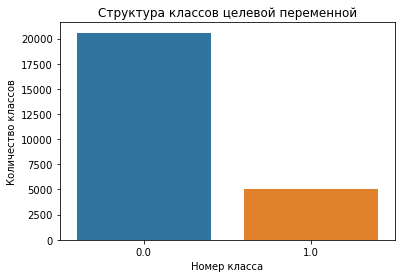

In [53]:
class_vc = df.groupby(['cl_id'])['def'].mean().value_counts()
plot = sns.barplot(x = class_vc.index, y = class_vc)
plot.set_title('Структура классов целевой переменной')
plot.set_xlabel('Номер класса')
plot.set_ylabel('Количество классов');

#fig.write_image('figures/fig_1.png')

In [54]:
df.groupby(['cl_id'])['def'].mean().value_counts(normalize = True)

0.0    0.803592
1.0    0.196408
Name: def, dtype: float64

Дефолотов у клиентов существенно меньше, присуствует умеренный дисбаланс классов.  
Вероятность дефолта по train выборке 0.196408

С помощью библиотеки dataprep подробнее взглянем на визуализацию пропусков, распределений и взаимосвязи признаков

In [55]:
# report = eda.create_report(df[df['def'].isna() == False])
# report.show_browser() # вывести отчёт в браузере
# report

С помощью библиотеки dataprep сравним распределения признаков в train и test выборках.

In [56]:
# report2 = eda.plot_diff([df[df['def'].isna() == False][features], pd.DataFrame(data = np.repeat(df[df['def'].isna() == True][features].values, 4, axis=0), columns = features)])
# report2.show_browser() # вывести отчёт в браузере
# report2

Во время 
EDA можно было увидеть, что первичным ключём к данным является id договора и в датасете есть повторяющиеся значения клиентов cl_id.  
Мы расположилии наш датасет в порядке времени заключения кредитного договора, посмотрим на то, может ли клиент с течением времени и попасть в дефолт, и закрывать договор без дефолта.

Мы видим, что в датасете представлены такие клиенты, которые могут либо находится в дефолте по всем договорам, либо не быть в дефолте.  
Было бы логично предположить, что после дефолта Score клиента (его качество) должно изменяться.

In [57]:
df.groupby(['cl_id'])['score'].std().value_counts()

0.0    24979
Name: score, dtype: int64

Мы этого не видим.

In [58]:
clients_std = df.groupby(['cl_id'])[features].std().fillna(0)
clients_std[clients_std == 0].dropna(axis = 1)

score  income  request_amt
cl_id                            
1        0.0     0.0          0.0
10       0.0     0.0          0.0
100      0.0     0.0          0.0
1000     0.0     0.0          0.0
10000    0.0     0.0          0.0
...      ...     ...          ...
9995     0.0     0.0          0.0
9996     0.0     0.0          0.0
9997     0.0     0.0          0.0
9998     0.0     0.0          0.0
9999     0.0     0.0          0.0

[25615 rows x 3 columns]

Мы видим, что ни у одного клиента за все годы не менялся доход, Score, пол, сфера деятельности заёмщика и запрашиваемая сумма.  
Откажемся от идеи временных рядов, т.к. в данном случае это выбивается из логики здравого смысла.  
Запомним признаки Sex, sector, score, request_amt. Далее пройдёмся по всем признакам, постараемся оценить их важность. 

А что с клиентами, которые встречаются в датасете лишь раз?

In [59]:
single_cl = df['cl_id'].value_counts()[df['cl_id'].value_counts() == 1].index
df[df['cl_id'].isin(single_cl)]['def'].value_counts(normalize=True)

0.0    0.721698
1.0    0.278302
Name: def, dtype: float64

Для клиентов с единственной записью вероятность попасть в дефолт выше, чем в среднем по выборке.  

Для моделирования задачи введём новый таргет 'def_2' и заполним пропусками 20% предполагаемых тестовых данных.  
Это не будет мешать нам анализировать взаимосвязь признаков и целевой переменной.  
В конце задачи используем таргет 'def' для оценки качества решения.  

In [60]:
df['def_2'] = df['def']
df.loc[np.arange(int(df.shape[0] * 0.8), df.shape[0]), 'def_2'] = np.NaN

In [61]:
df['def_2'].head(5)

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: def_2, dtype: float64

In [62]:
df['def_2'].tail(5)

592190   NaN
592191   NaN
592192   NaN
592193   NaN
592194   NaN
Name: def_2, dtype: float64

## Категориальные признаки

In [63]:
df[cat_feats].nunique()

birthplace             14983
cred_partner_type          8
cred_currency              5
cred_special_status        4
grace_type                 3
grace_reason               7
grace_endreason            4
cred_collateral            3
cred_type                 20
cred_active               19
cred_sum_type              3
sex                        2
sector                    17
cl_id                  25615
cred_ratio                 4
dtype: int64

In [64]:
# мы уже заменили пропуски на 'nan'
df[cat_feats].isna().sum()

birthplace             0
cred_partner_type      0
cred_currency          0
cred_special_status    0
grace_type             0
grace_reason           0
grace_endreason        0
cred_collateral        0
cred_type              0
cred_active            0
cred_sum_type          0
sex                    0
sector                 0
cl_id                  0
cred_ratio             0
dtype: int64

Отсортируем категориальные признаки с высокой мощностью в корзины с минимальной долей объектов 0.05  
Упорядочим их по влиянию на таргет.  
Посмотрим влияние корзин категориальных признаков на вероятность дефолта. 
Увидим WeightOfEvidance, вычислим InformationValue для каждого признака.


birthplace_bins005   IV score: 0.0146



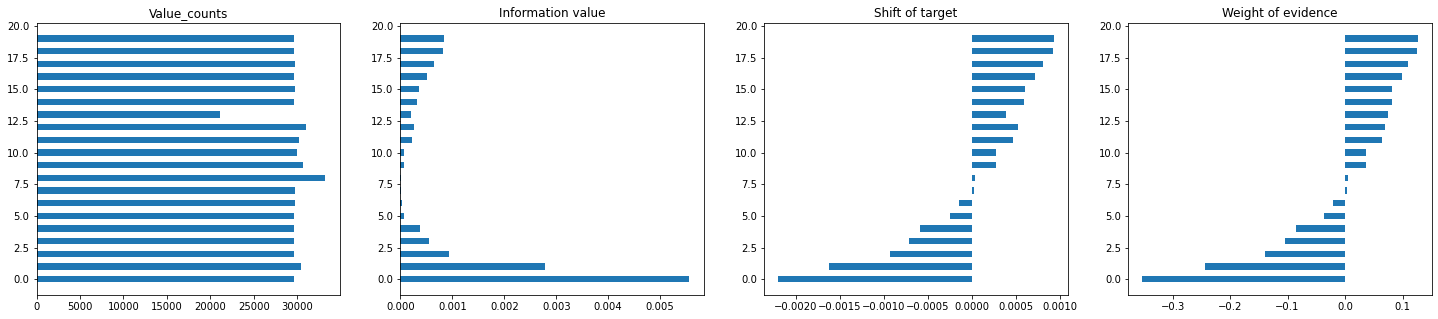



cred_partner_type_bins005   IV score: 0.0027



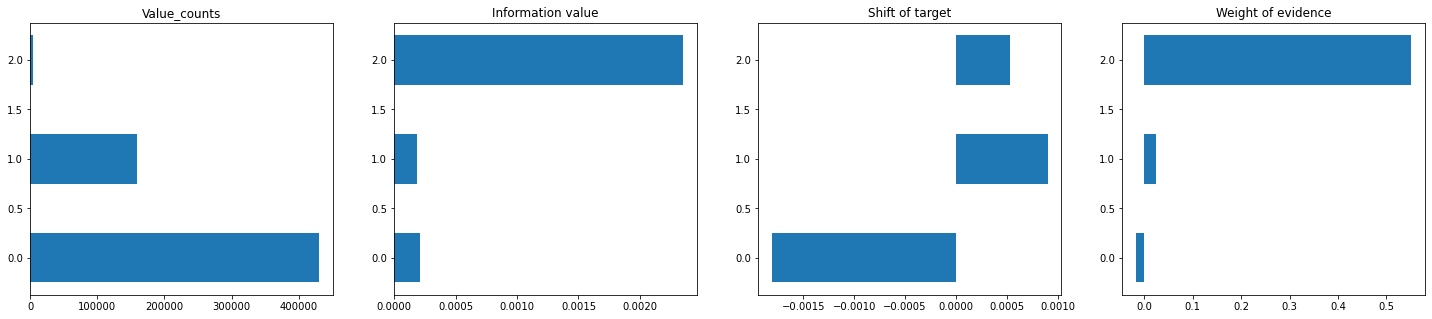



cred_currency_bins005   IV score: 0.0000



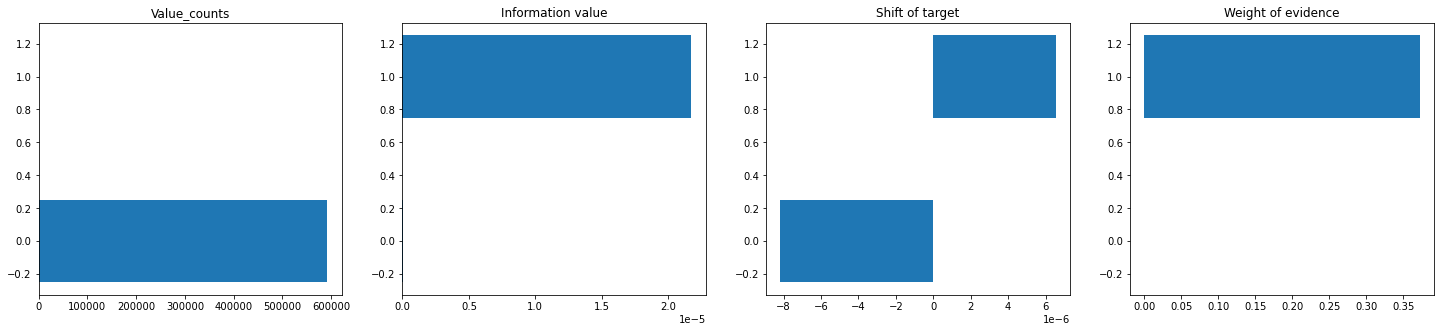



cred_special_status_bins005   IV score: 0.0000



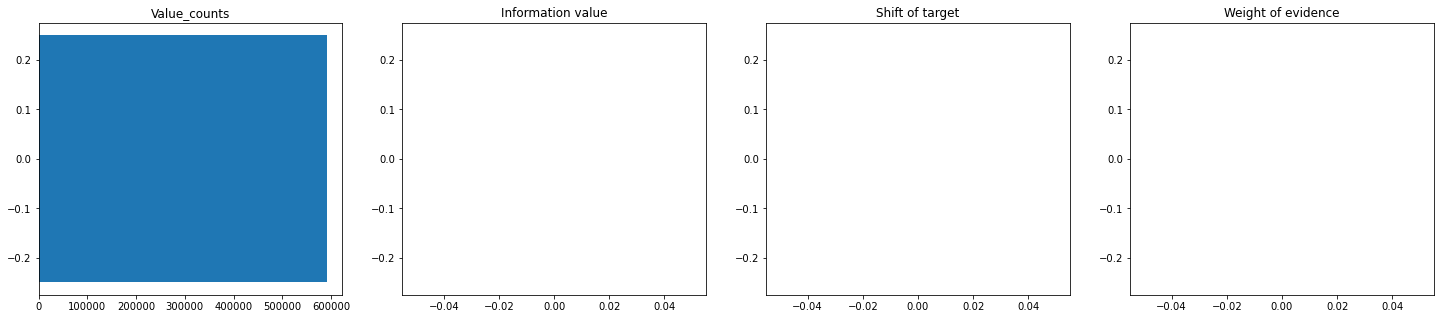



grace_type_bins005   IV score: 0.0000



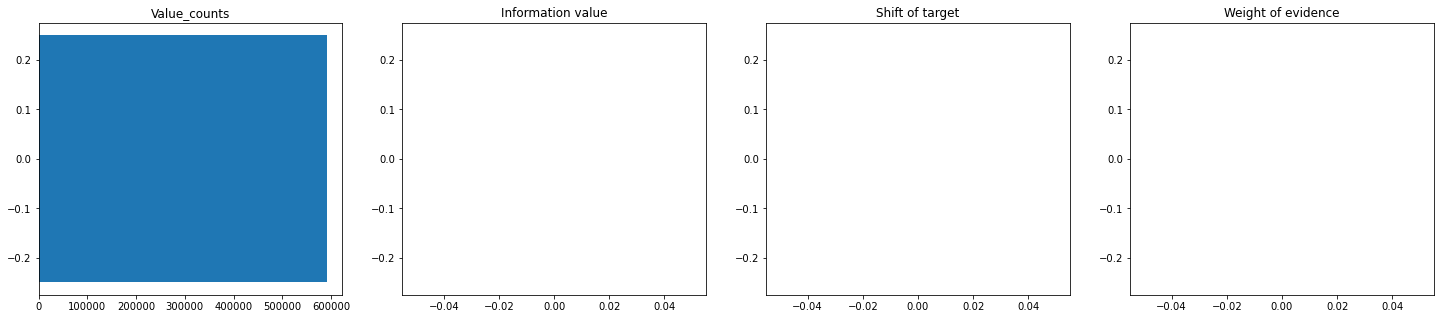



grace_reason_bins005   IV score: 0.0000



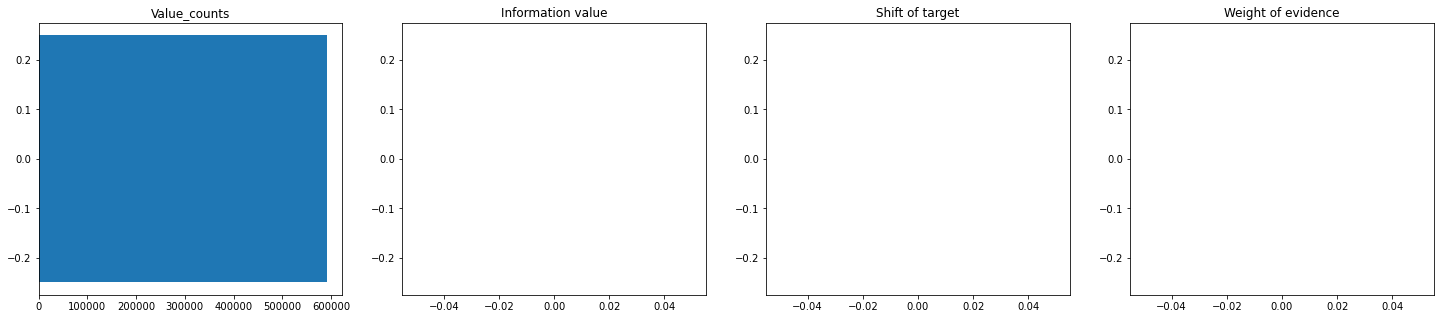



grace_endreason_bins005   IV score: 0.0000



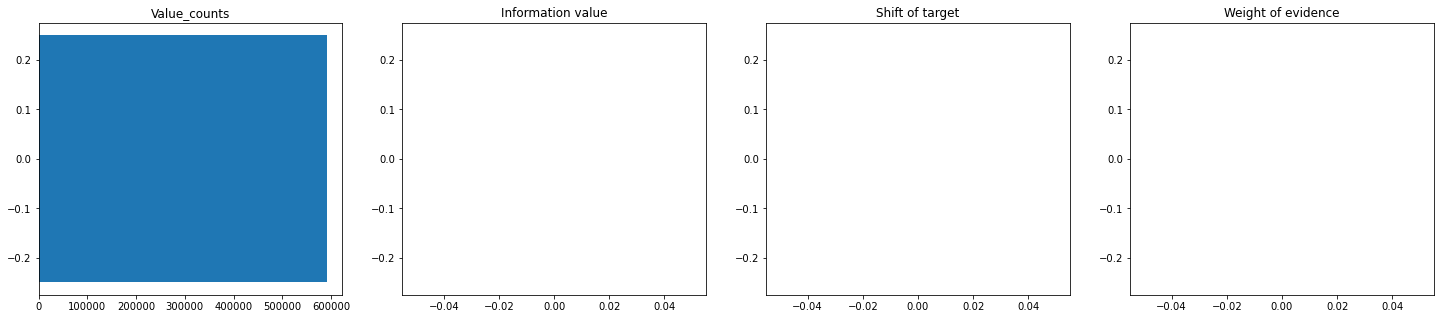



cred_collateral_bins005   IV score: 0.0000



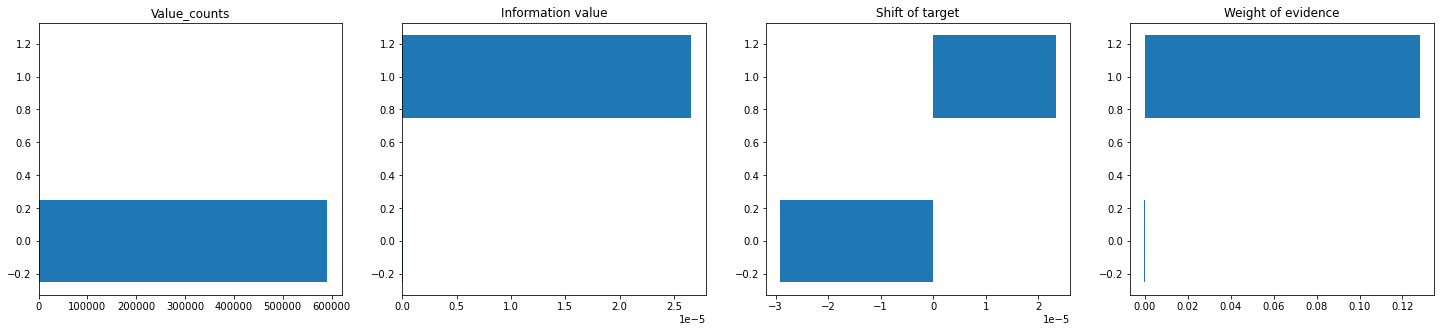



cred_type_bins005   IV score: 0.0045



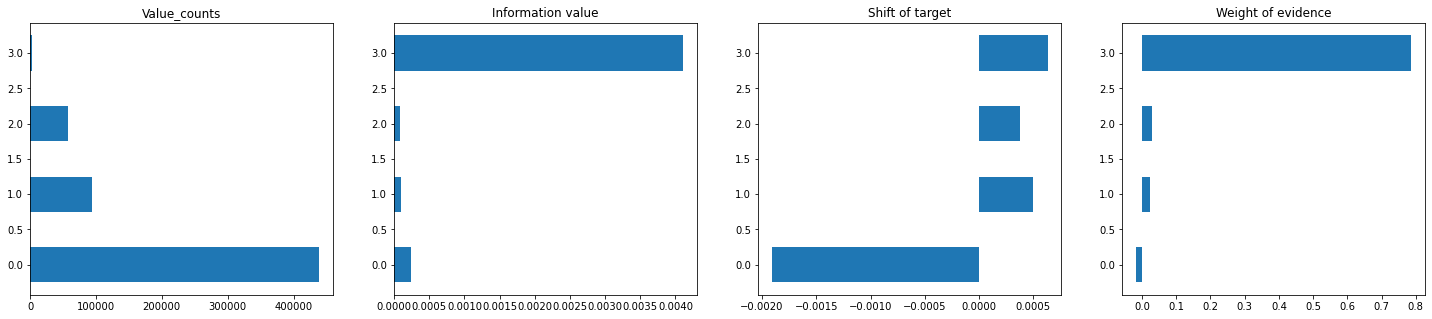



cred_active_bins005   IV score: 0.0189



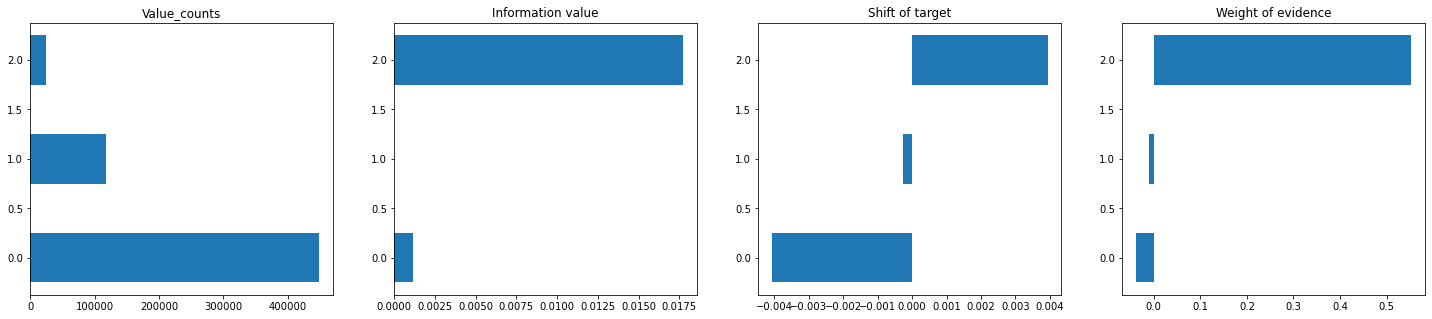



cred_sum_type_bins005   IV score: 0.0000



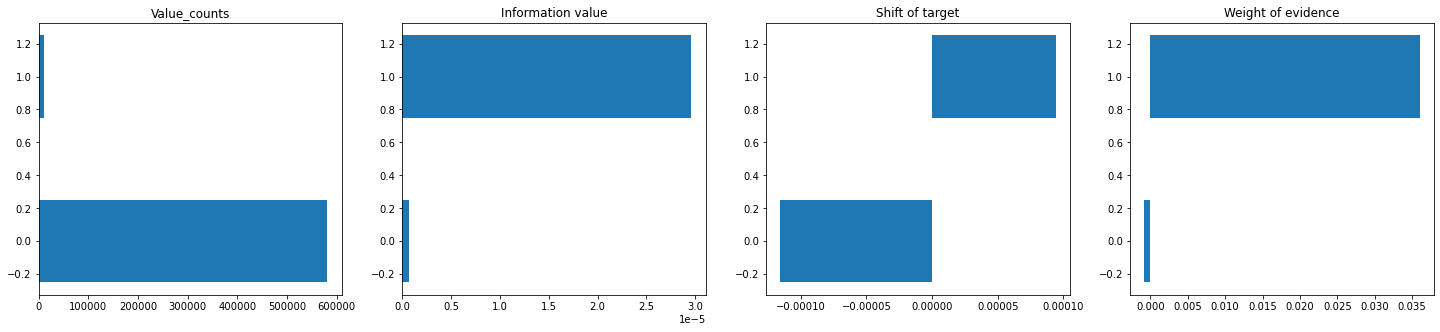



sex_bins005   IV score: 0.0062



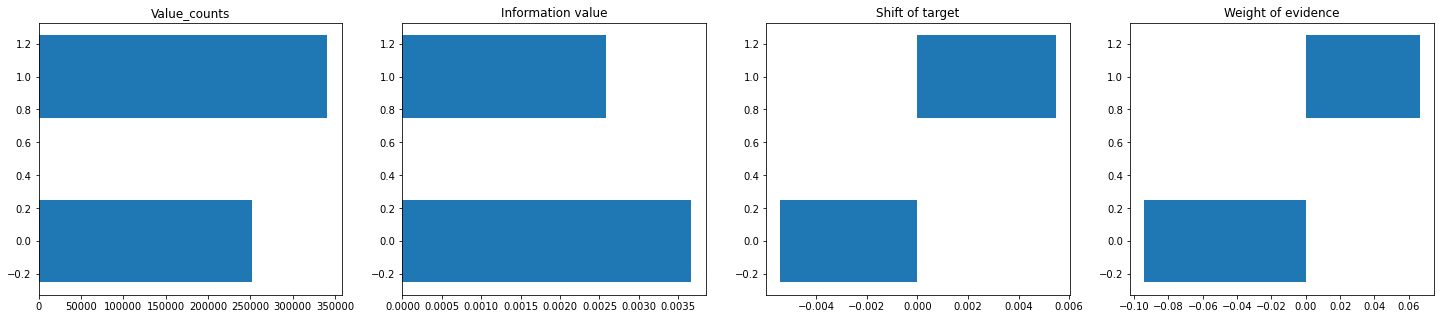



sector_bins005   IV score: 0.0192



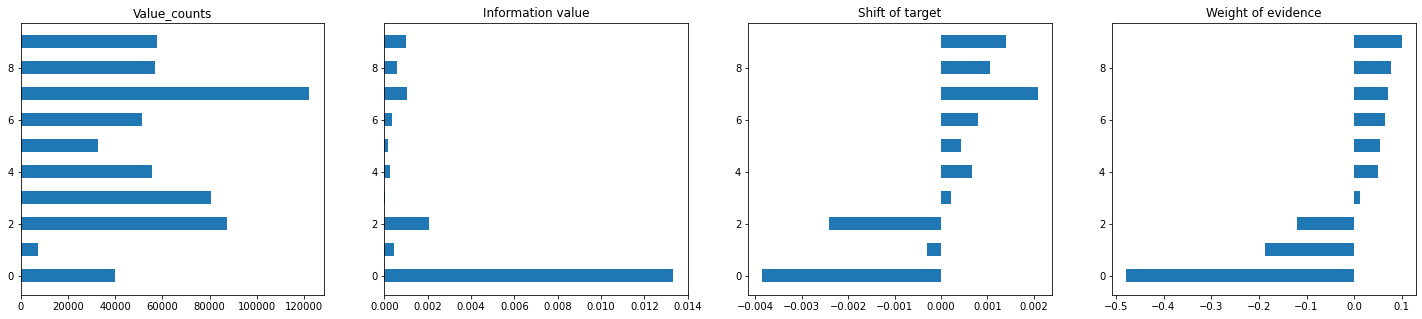



cl_id_bins005   IV score: 0.0195



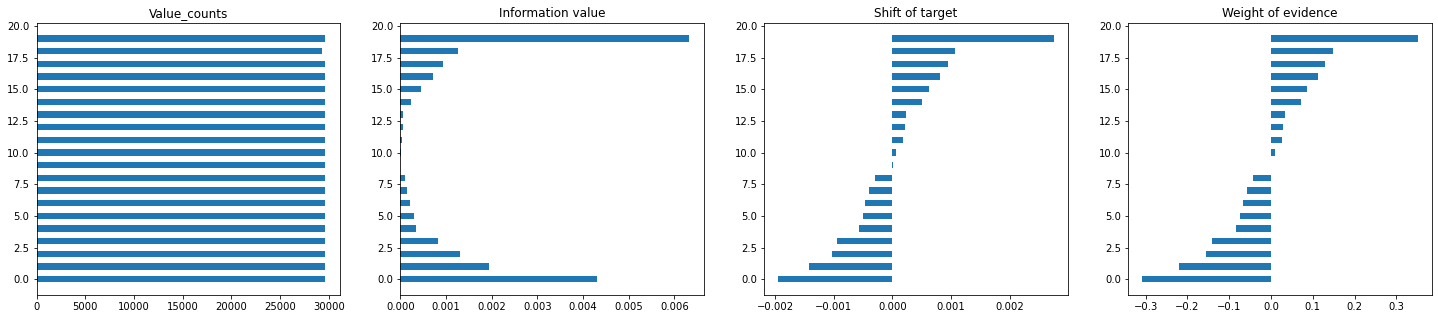



cred_ratio_bins005   IV score: 0.0000



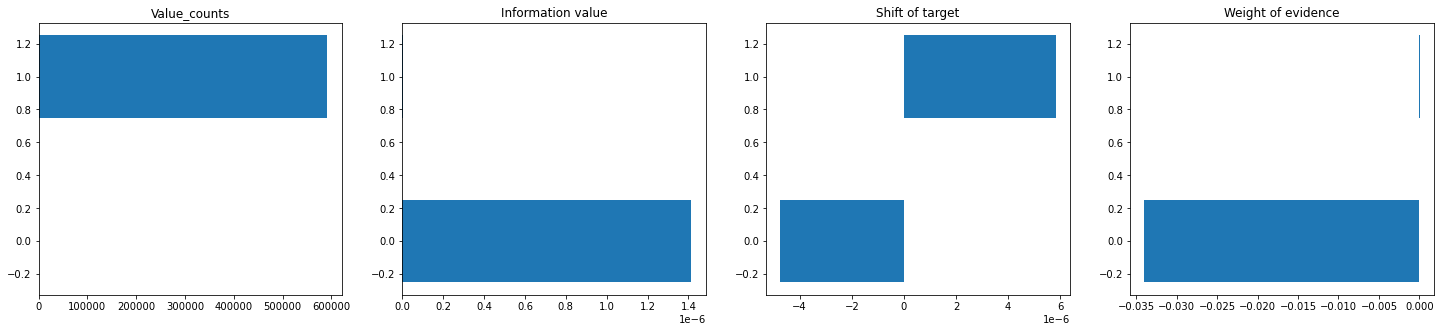

In [65]:
df, cat_bins = col_by_bins(df, cat_feats, 0.05)
df = order_values (df, cat_bins, 'def_2')
print_barhs(df, cat_bins, 'def_2')

Видим относительно приемлимую важность (> 0.01) у признаков birthplace, cred_active, sector.  
Признаки, в которых одно уникальное значение занимает более 0.95 от объёма признака на данном этапе не берём.

## Дискретные числовые

Посмотрим на распределения числовых дискретных признаков. Сразу посмотрим стоит ли что-то логарифмировать.

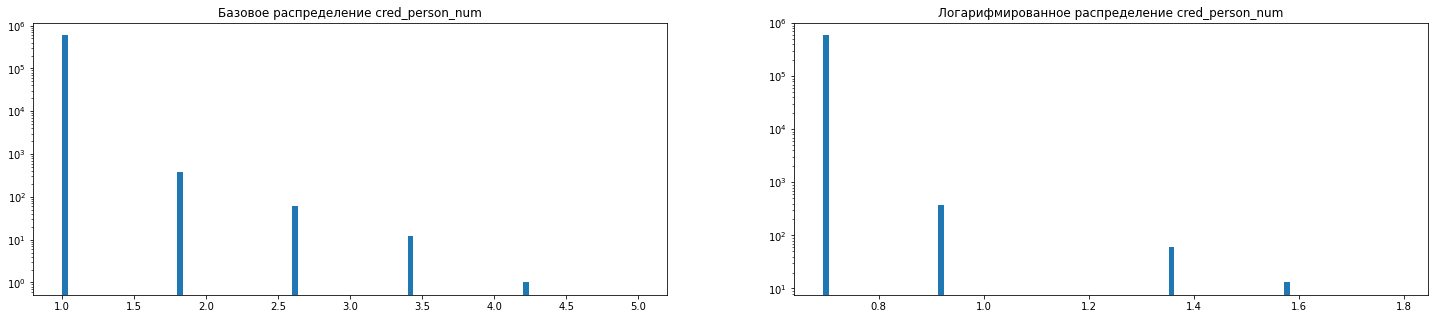

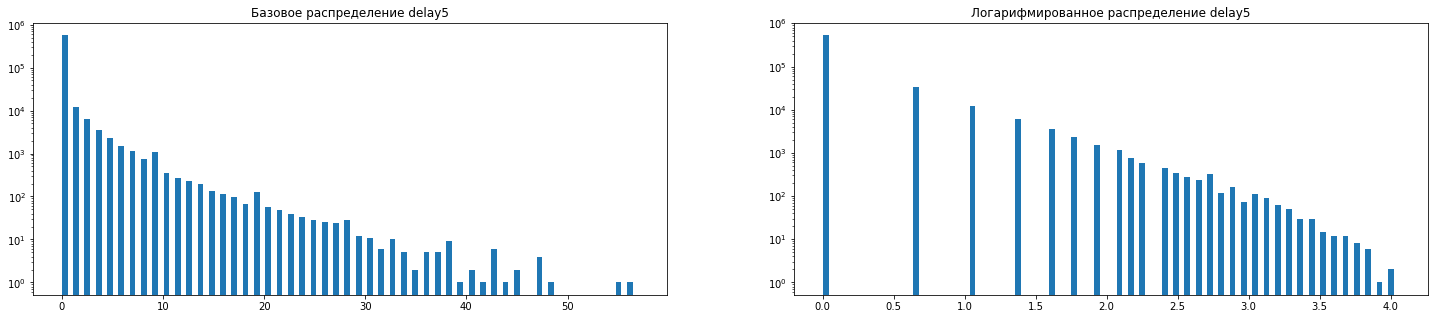

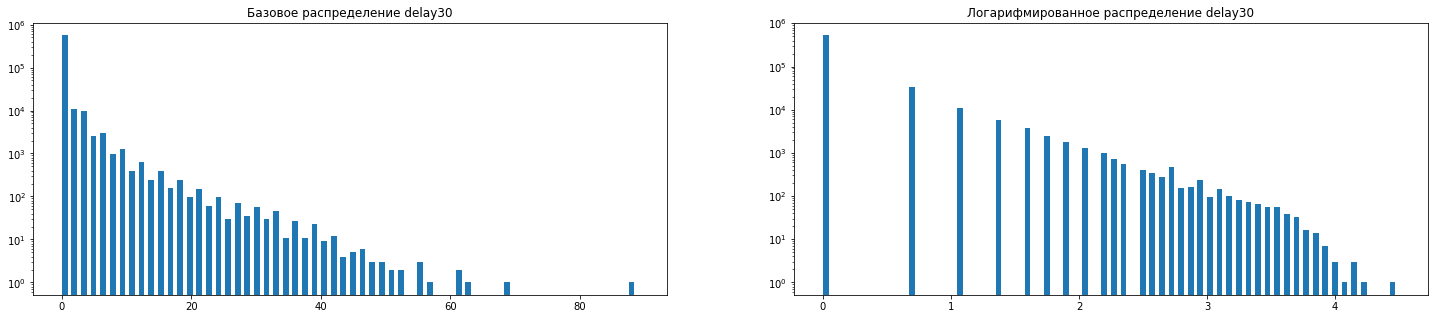

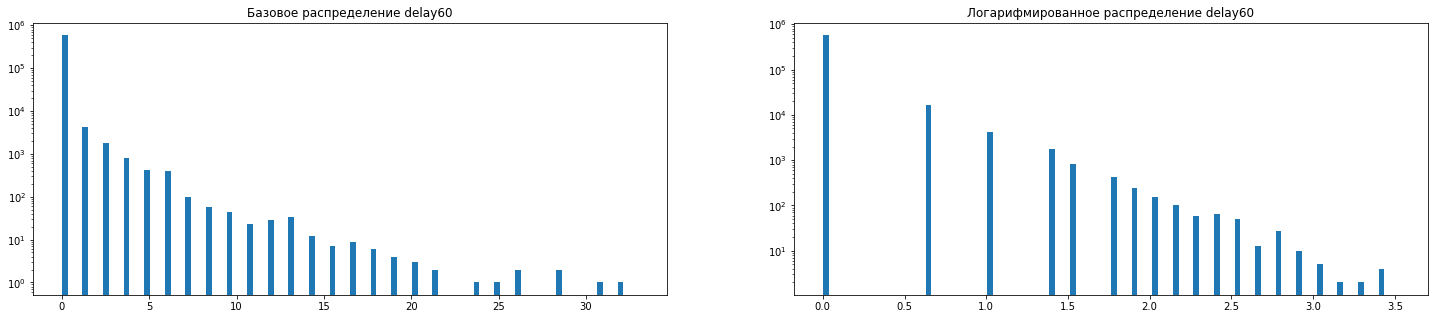

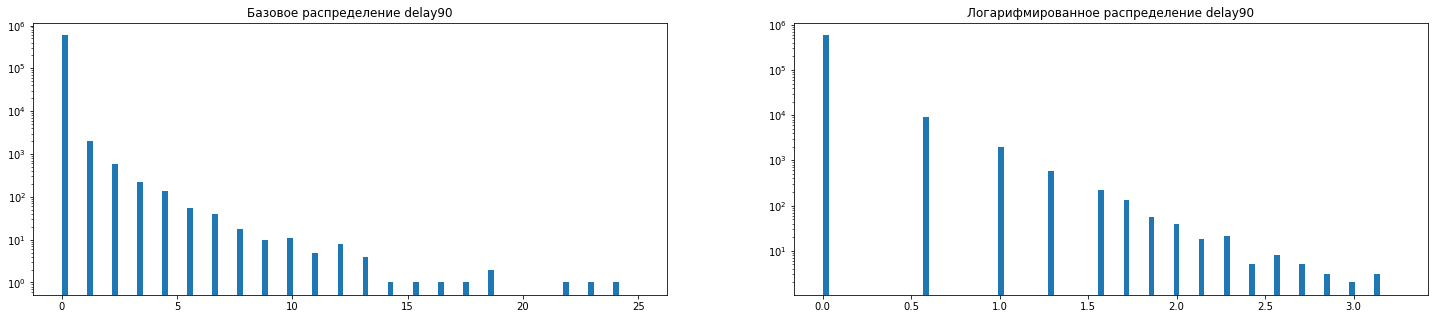

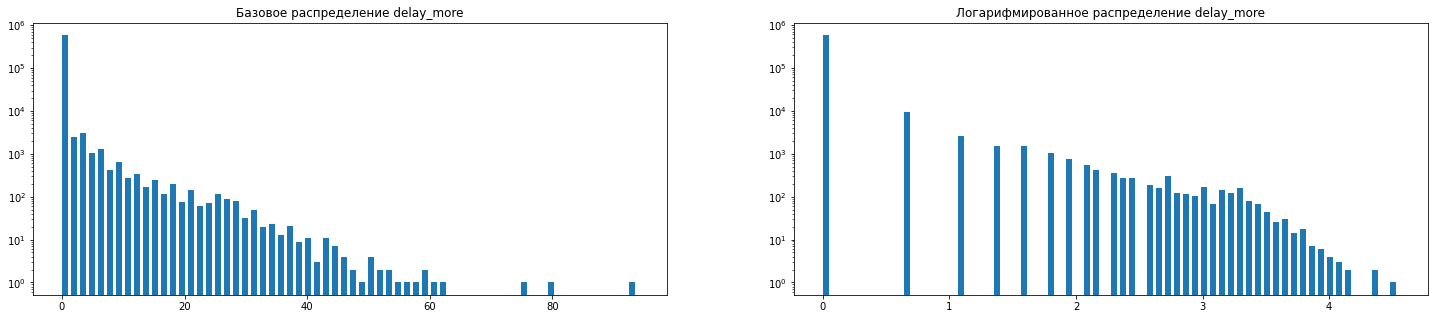

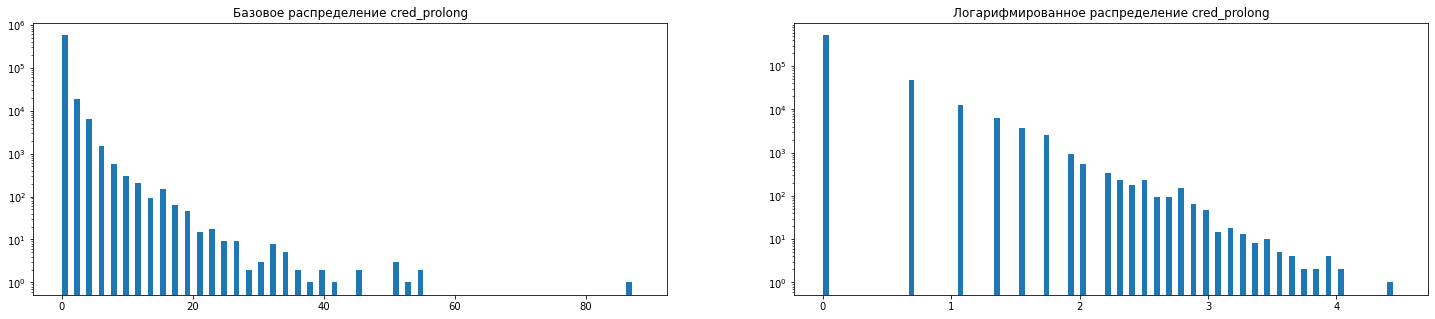

In [66]:
hist_log_compare (df, num_discret_feats)

In [67]:
# sns.pairplot(
#     df[num_discret_feats + ['def_2']],
#     hue = 'def_2'
#     )

: 

In [ ]:
df, bin_ndisc_cols = col_by_bins(df, num_discret_feats, 0.05)
print_barhs(df,bin_ndisc_cols,'def_2')

Отметим низкий InformationValue у всех признаков

## Непрерывные числовые

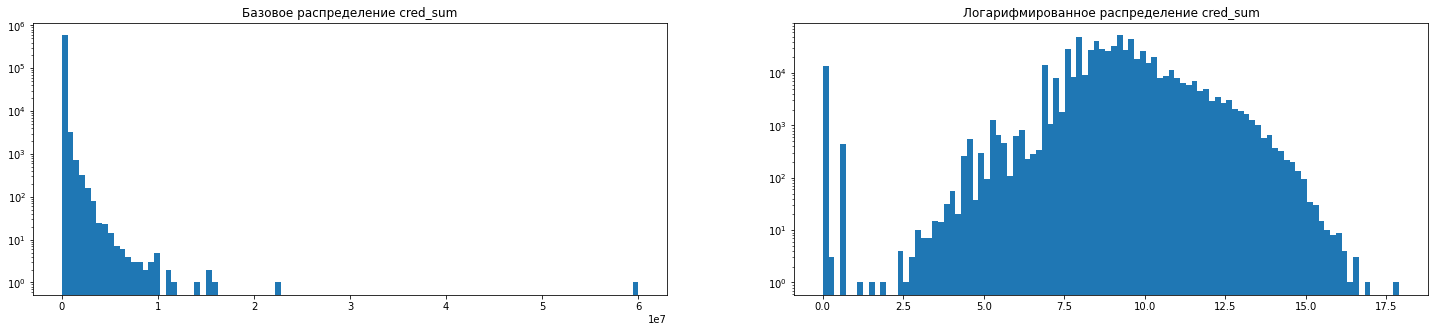

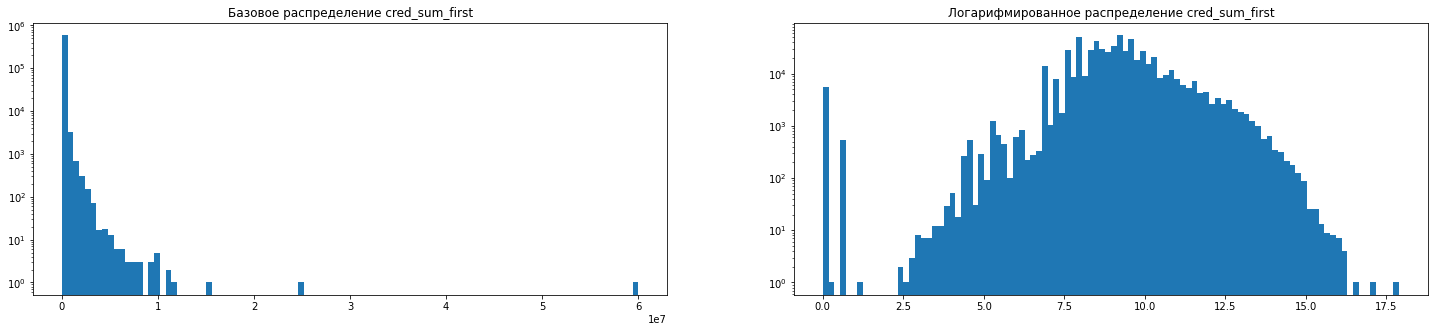

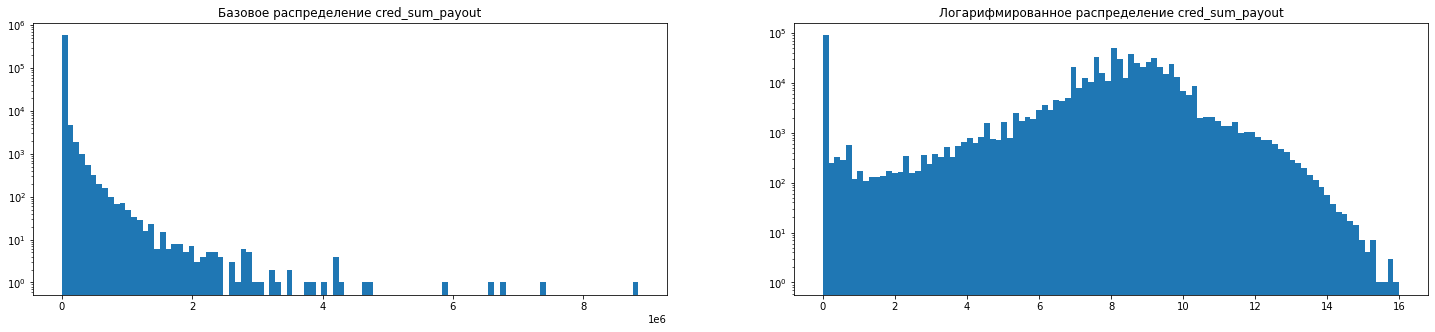

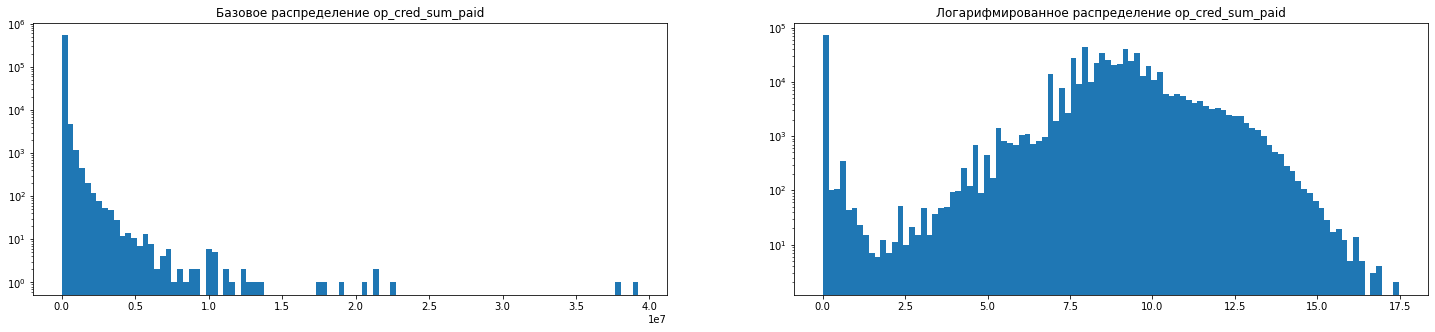

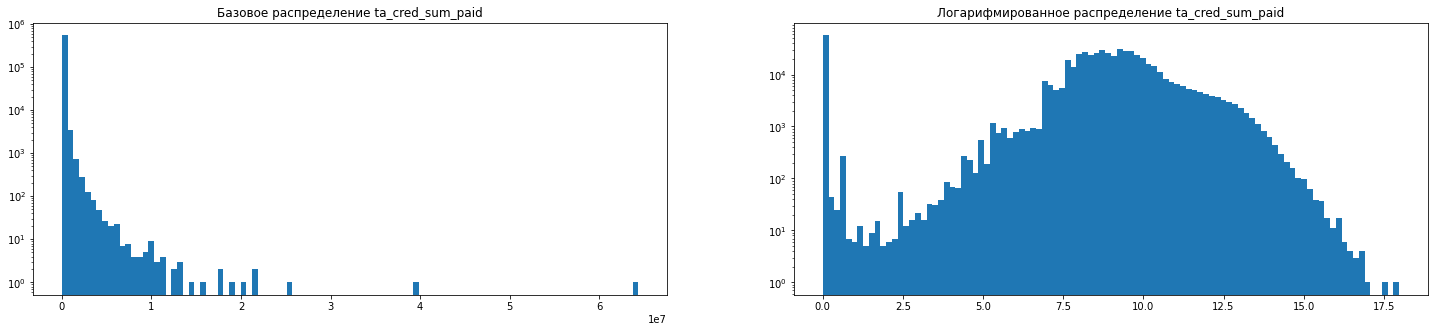

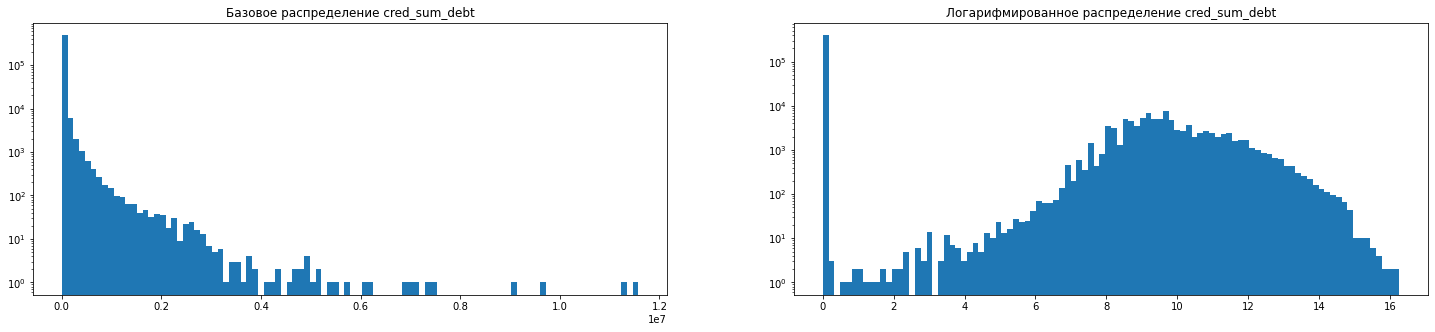

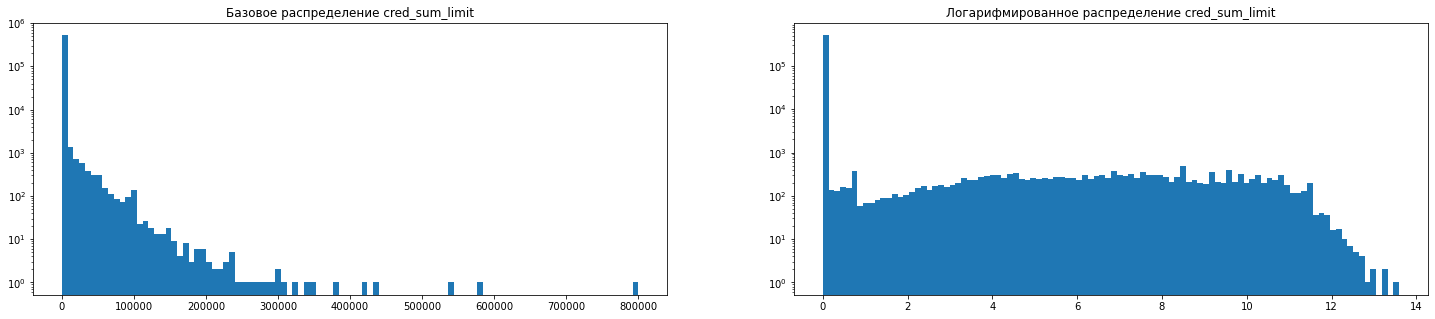

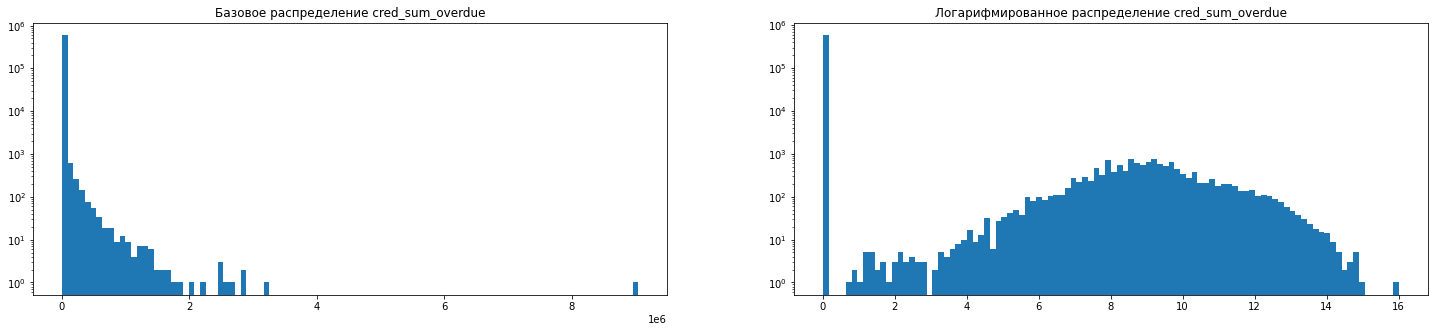

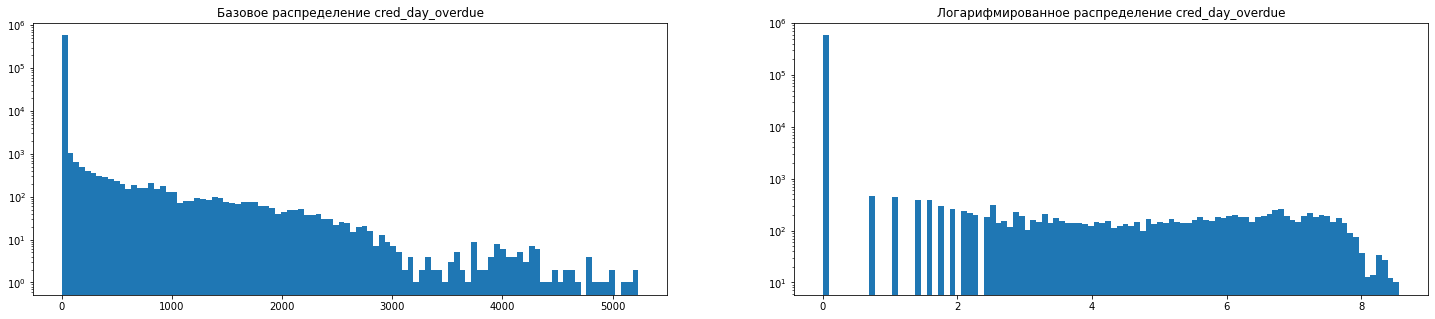

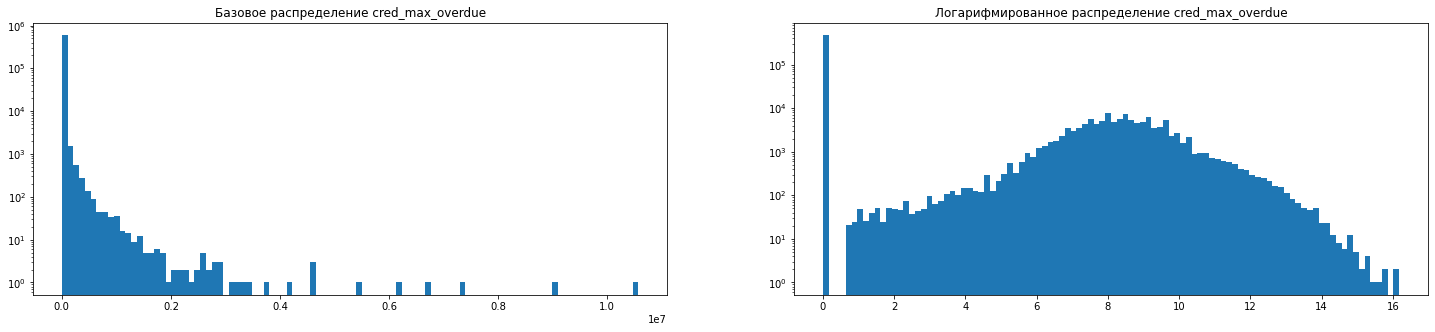

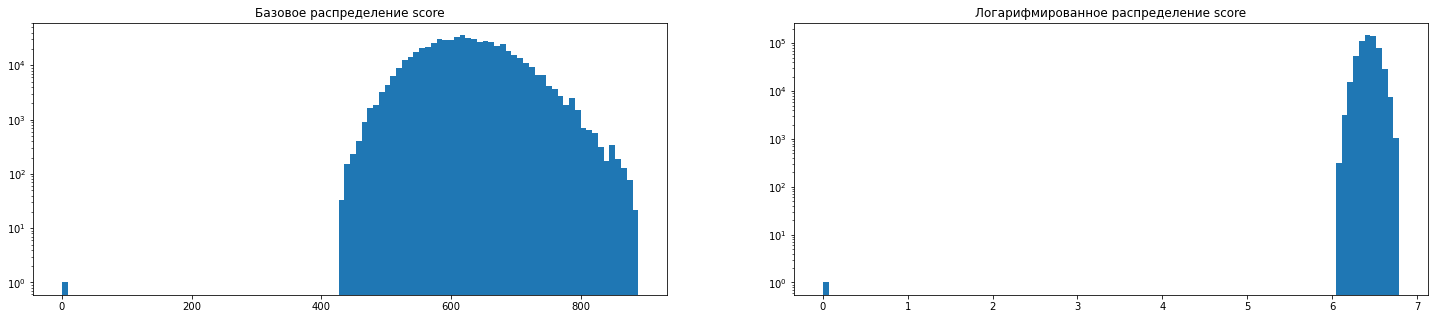

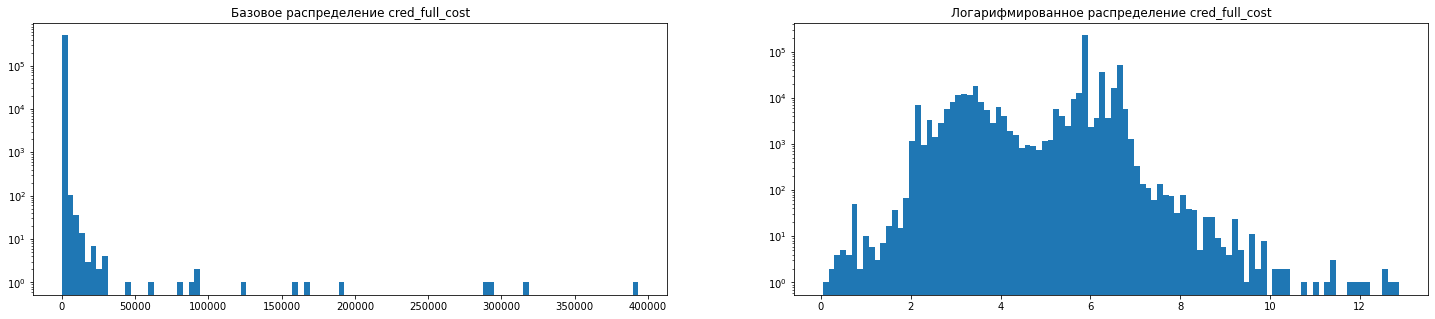

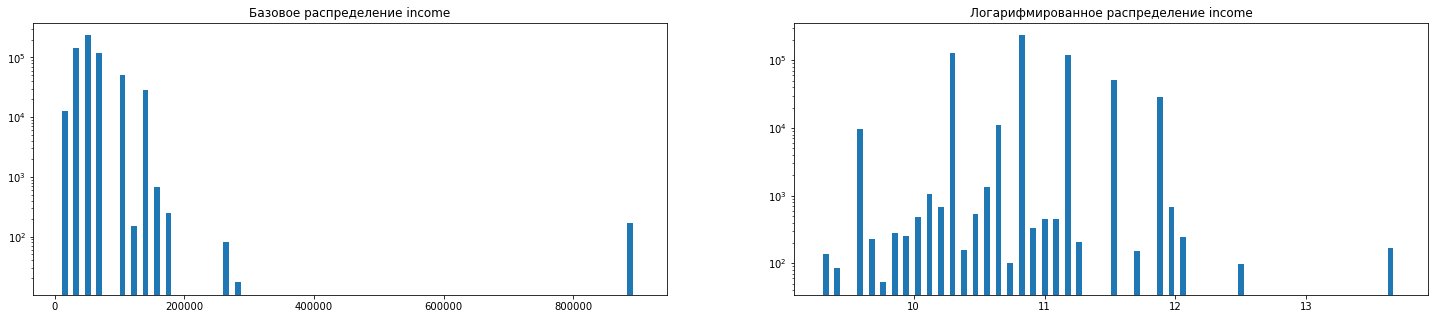

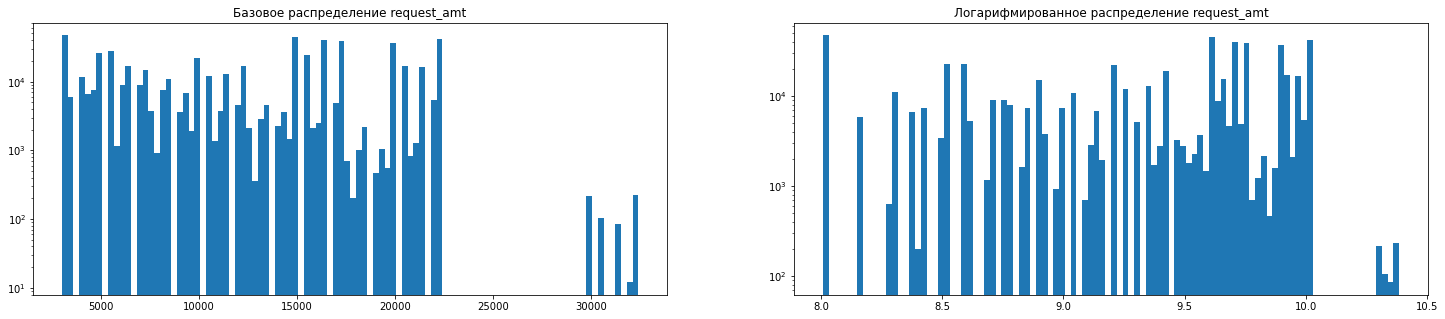

In [ ]:
hist_log_compare (df, num_contin_feats)

Чуть позже прологарифмируем часть признаков

In [ ]:
# подчистим одно значение
df.loc[df['score'] == 0, 'score'] = df['score'].median()

<AxesSubplot:>

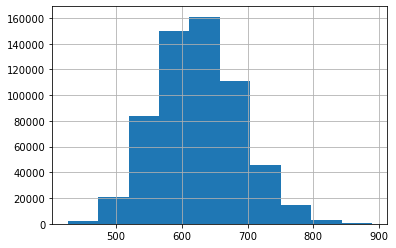

In [ ]:
df['score'].hist()


cred_sum_bins005   IV score: 0.0058



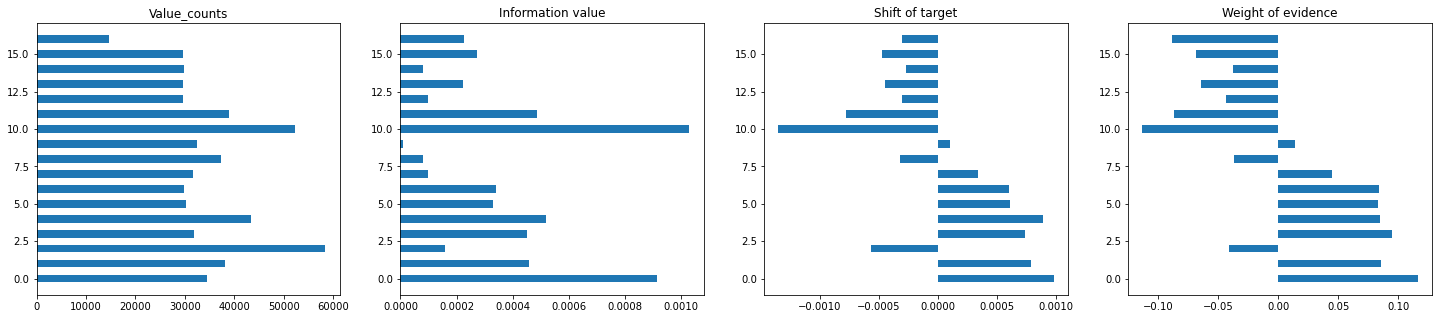



cred_sum_first_bins005   IV score: 0.0051



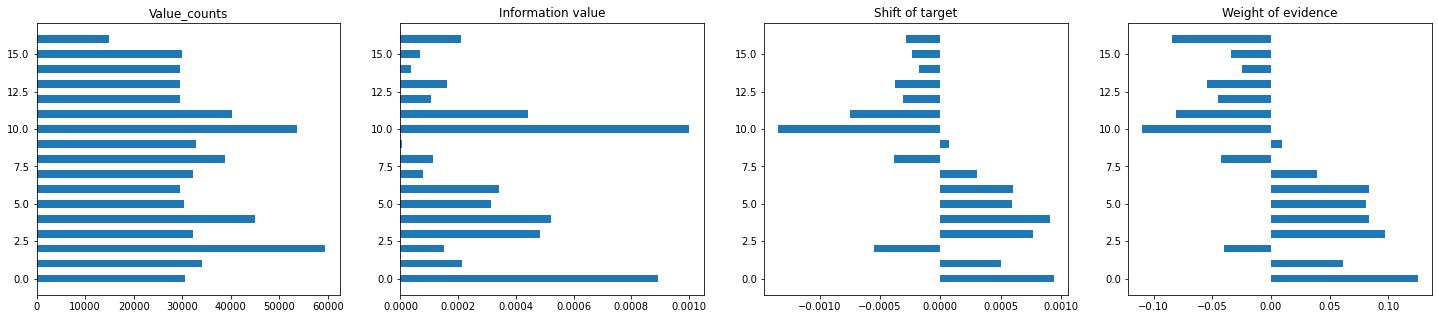



cred_sum_payout_bins005   IV score: 0.0159



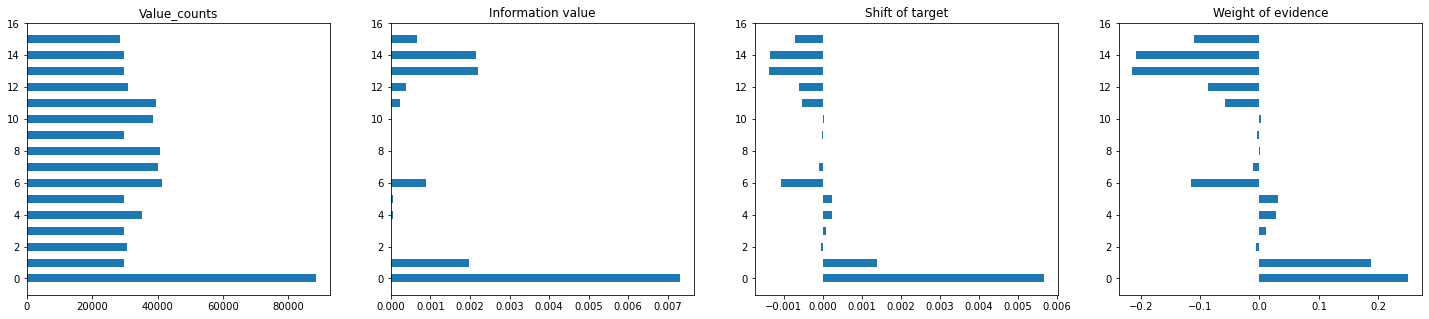



op_cred_sum_paid_bins005   IV score: 0.0167



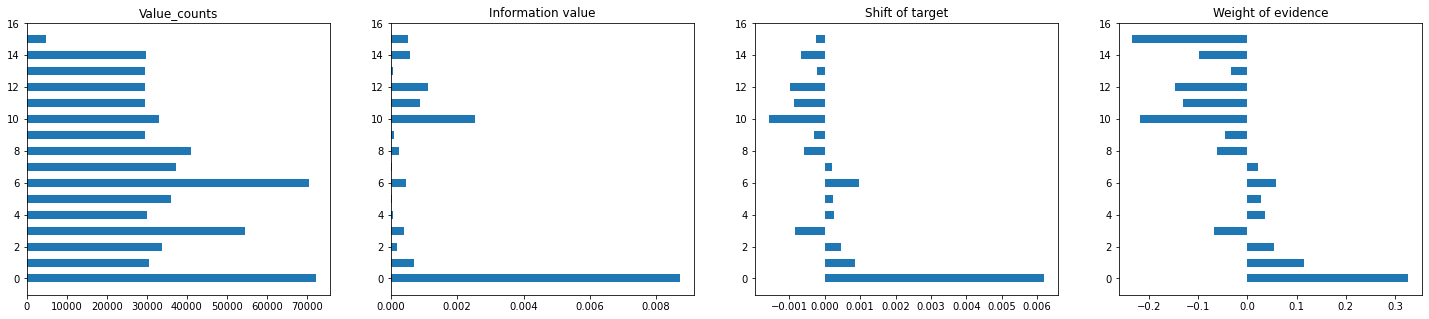



ta_cred_sum_paid_bins005   IV score: 0.0119



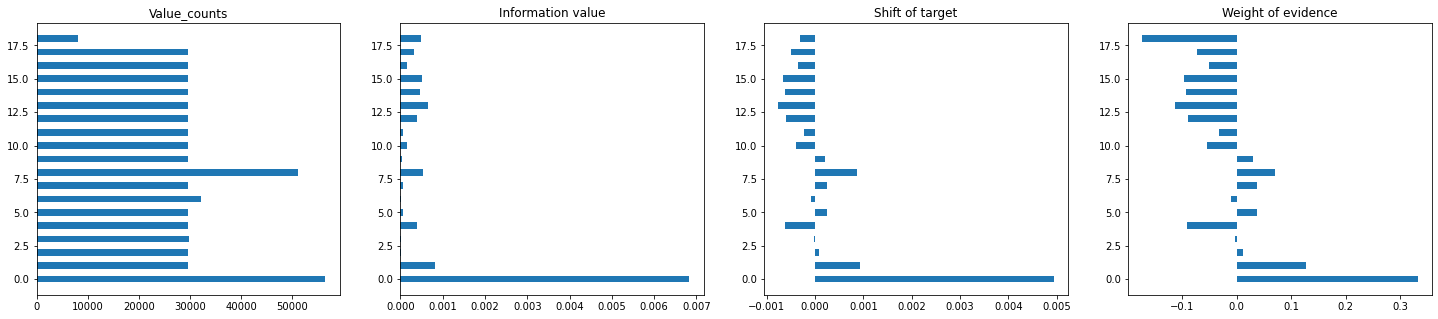



cred_sum_debt_bins005   IV score: 0.0030



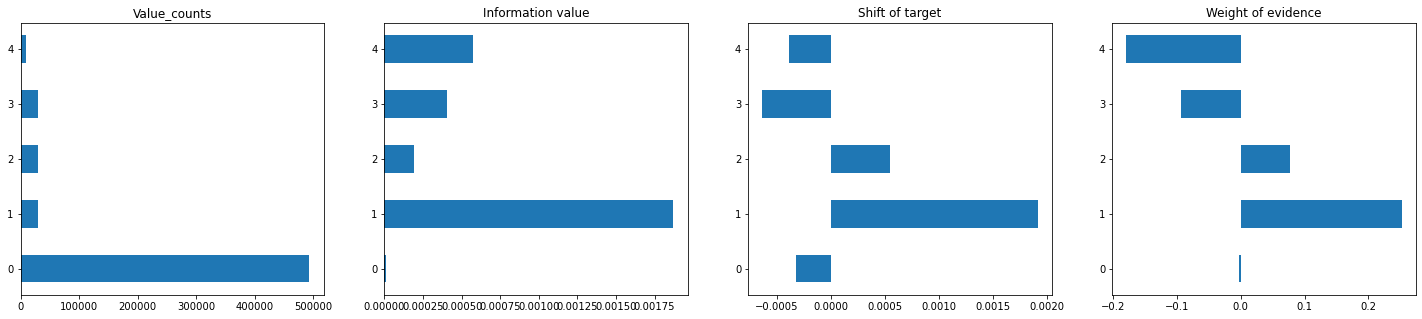



cred_sum_limit_bins005   IV score: 0.0001



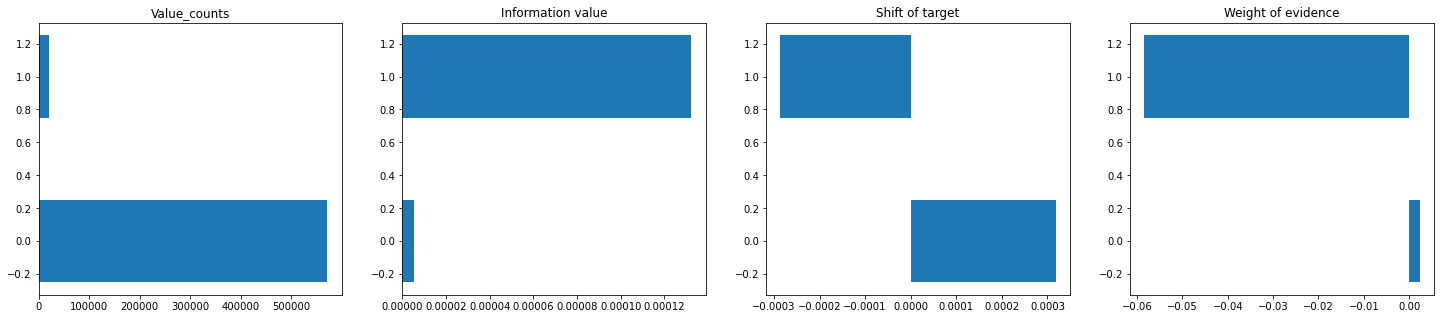



cred_sum_overdue_bins005   IV score: 0.0178



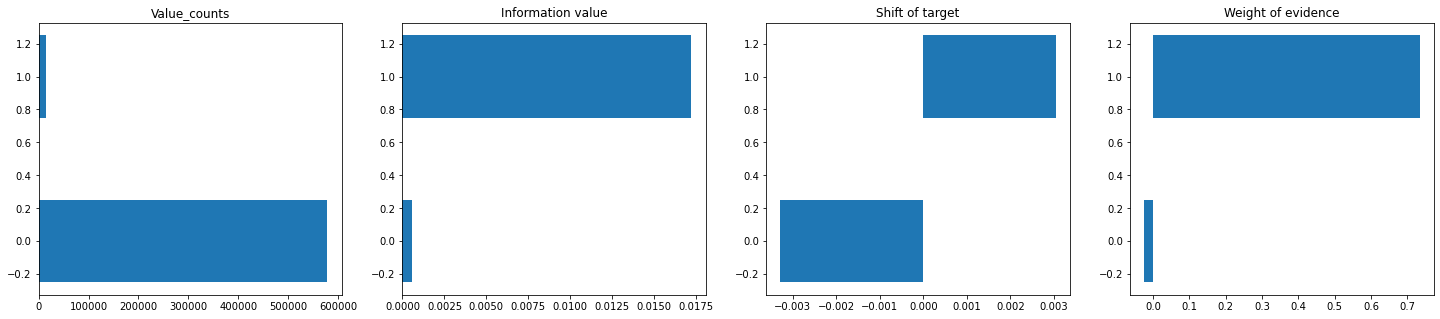



cred_day_overdue_bins005   IV score: 0.0176



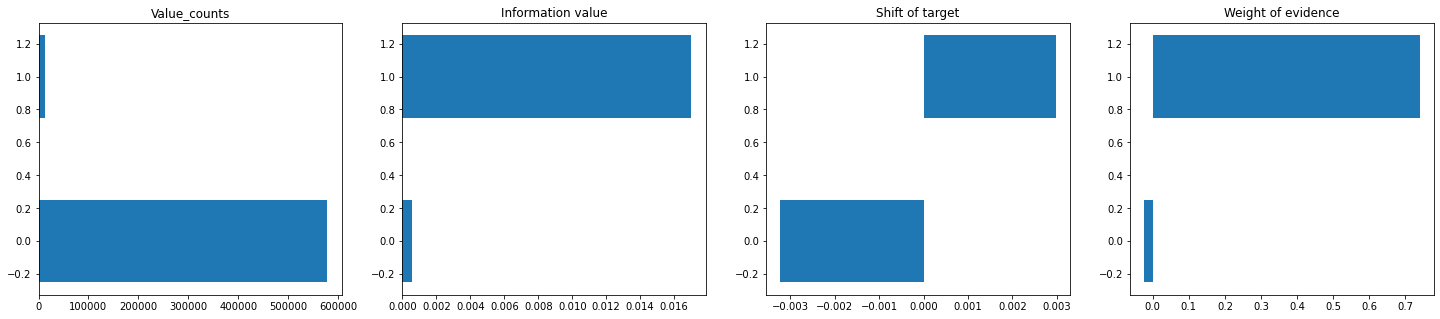



cred_max_overdue_bins005   IV score: 0.0211



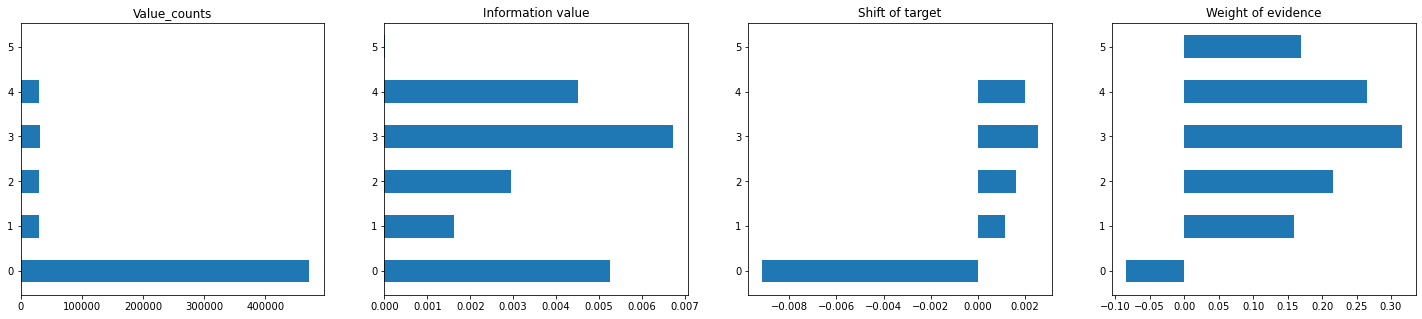



score_bins005   IV score: 0.5571



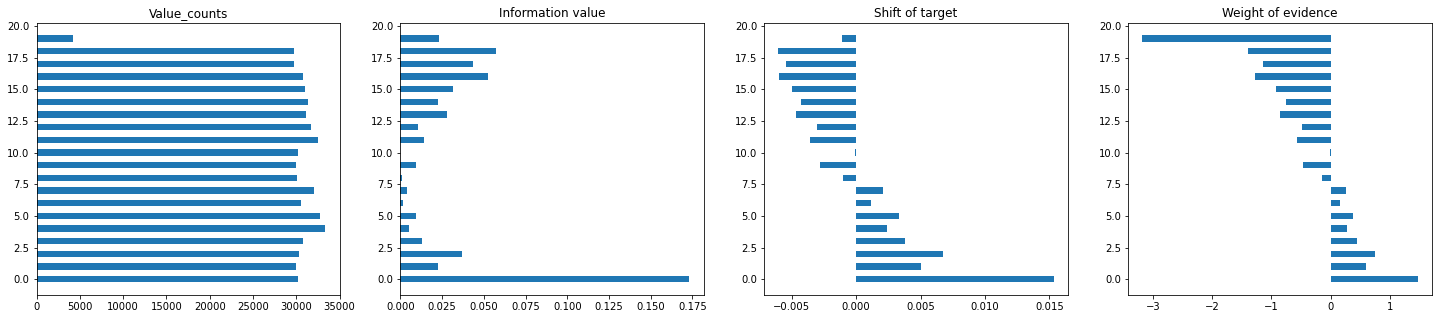



cred_full_cost_bins005   IV score: 0.0049



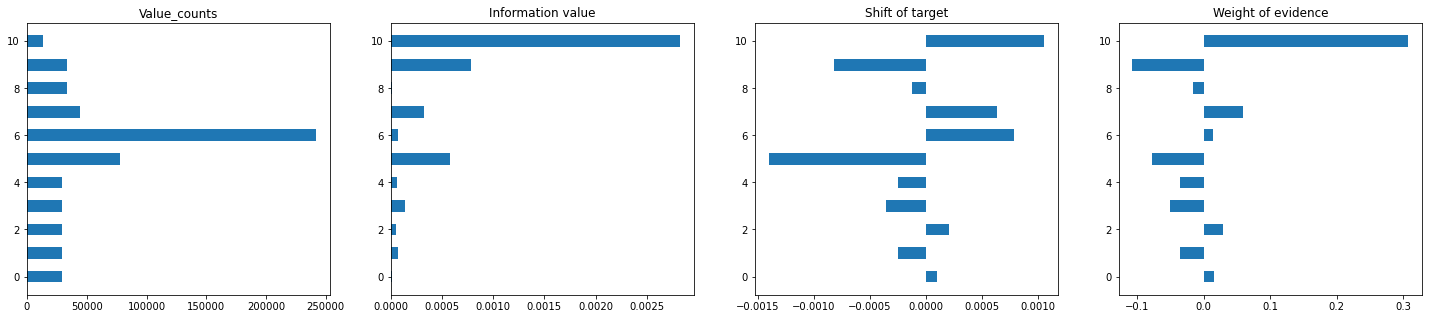



income_bins005   IV score: 0.0380



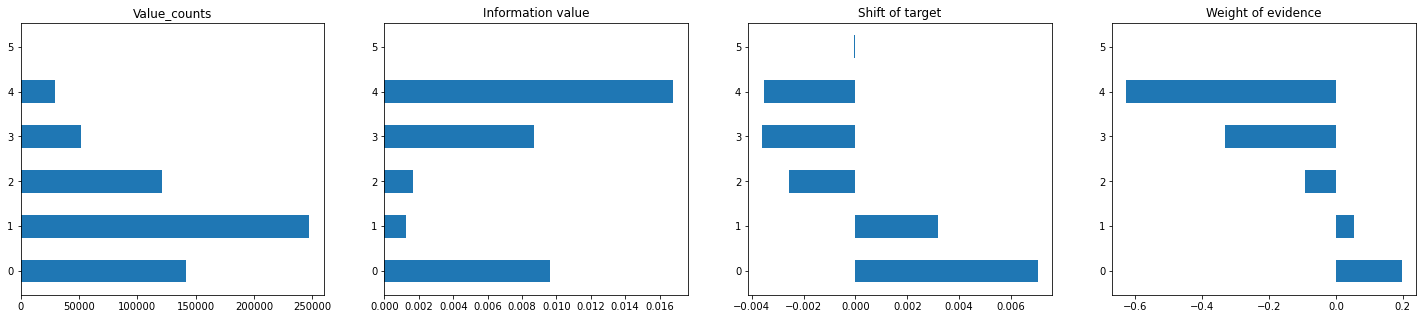



request_amt_bins005   IV score: 0.0264



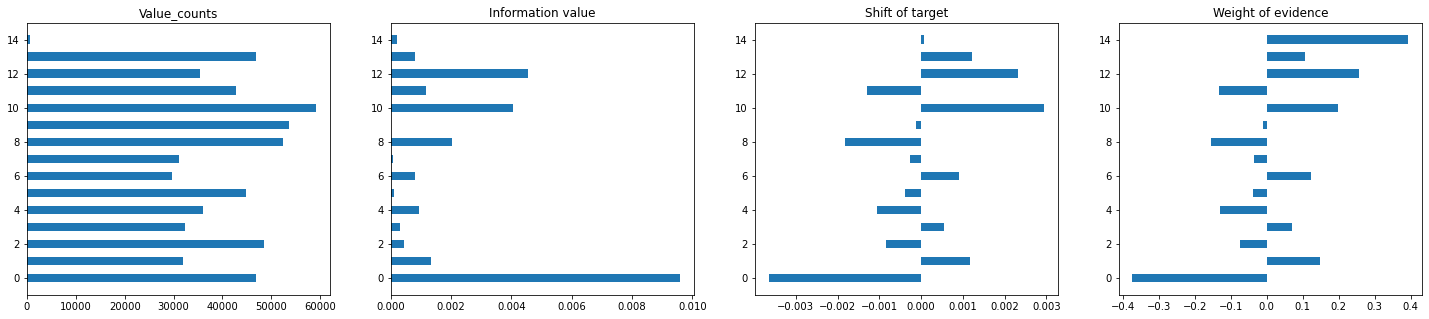

In [ ]:
df, bin_ncont_cols = col_by_bins(df, num_contin_feats, 0.05)
print_barhs(df,bin_ncont_cols,'def_2')

Ещё раз отметим признаки, которые показывают сравнительно лучшую значимость по IV: request_amt, income и особенно score.  
Также не будем отбрасывать cred_max_overdue, cred_day_overdue, cred_sum_overdue, cred_sum_payout, op_cred_sum_paid

In [ ]:
# удалим часть предполагаемых выбросов и поставим флаг об изменении

flags = []
df['request_amt_25000'] = np.where(df['request_amt'] > 25000, 1, 0)
df['income_400000'] = np.where(df['income'] > 4e5, 1, 0)
# df['score_under_400'] = np.where(df['score'] < 400, 1, 0)

df['request_amt_edited'] = np.where(df['request_amt_25000'] == 1, df['request_amt'].median(), df['request_amt'])
df['income_edited'] = np.where(df['income_400000'] == 1, df['income'].median(), df['income'])

flags.extend(['request_amt_25000', 'income_400000'])

In [ ]:
# прологарифмируем часть выбранных признаков
to_log_cols = [
    'income_edited',
    'request_amt_edited',
    'cred_max_overdue',
    'cred_sum_overdue',
    'cred_sum_payout',
    'op_cred_sum_paid',
    'ta_cred_sum_paid'
]

log_feats = list(map(lambda x: x +'_log', to_log_cols))
df[log_feats] = np.log(df[to_log_cols] + 1)

# создадим список новых числовых признаков
new_num_feats = ['score'] + log_feats

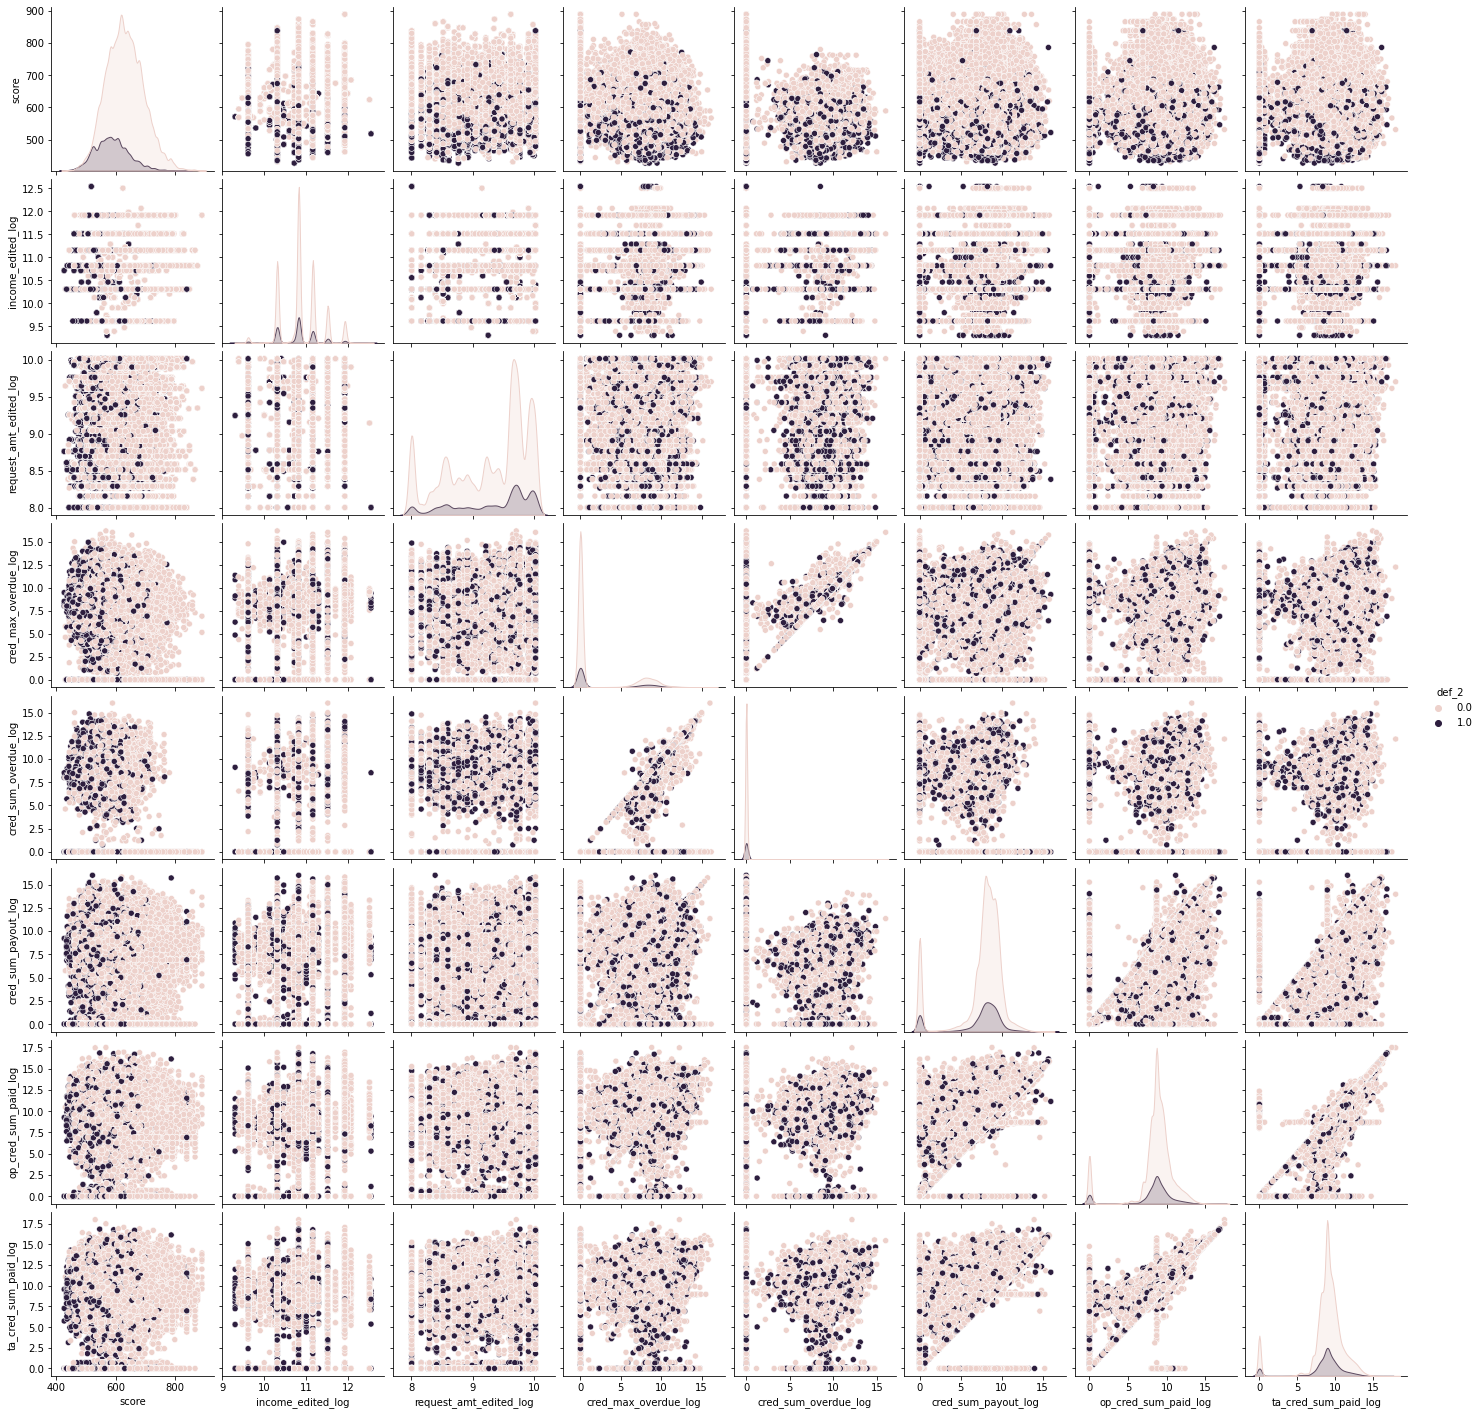

In [72]:
# sns.pairplot(
#     df[new_num_feats + ['def_2']],
#     hue = 'def_2'
#     )

## Dates

In [42]:
new_date_feats = []
for col in date_feats:
    year_col = '_'.join([col, 'year'])
    df[year_col] = df[col].dt.year

    month_col = '_'.join([col, 'month'])
    df[month_col] = df[col].dt.month

    day_col = '_'.join([col, 'day'])
    df[day_col] = df[col].dt.day

    new_date_feats.extend([year_col, month_col, day_col])


cred_date_year_bins005   IV score: 0.0016



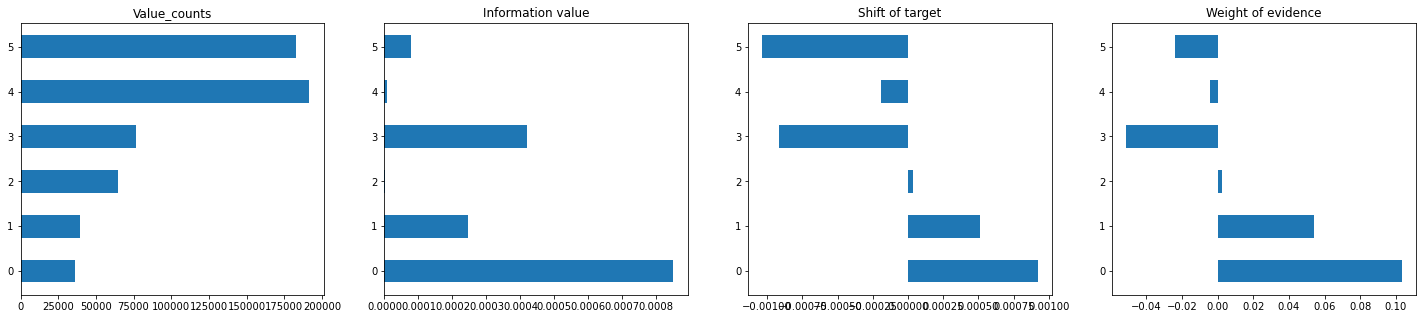



cred_date_month_bins005   IV score: 0.0002



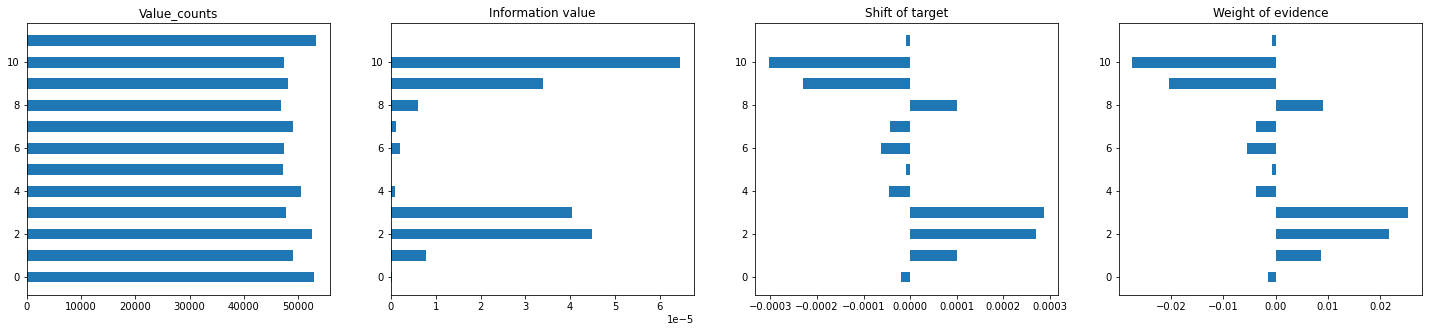



cred_date_day_bins005   IV score: 0.0005



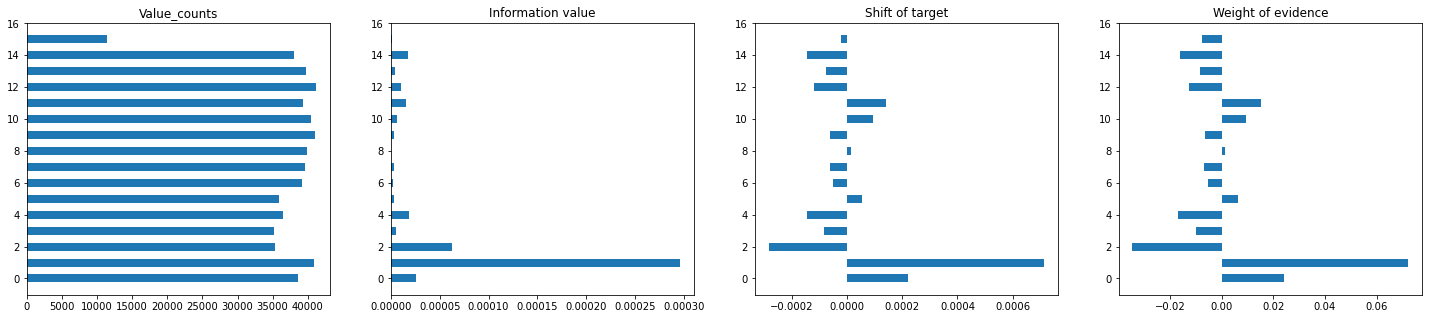



cred_enddate_year_bins005   IV score: 0.0026



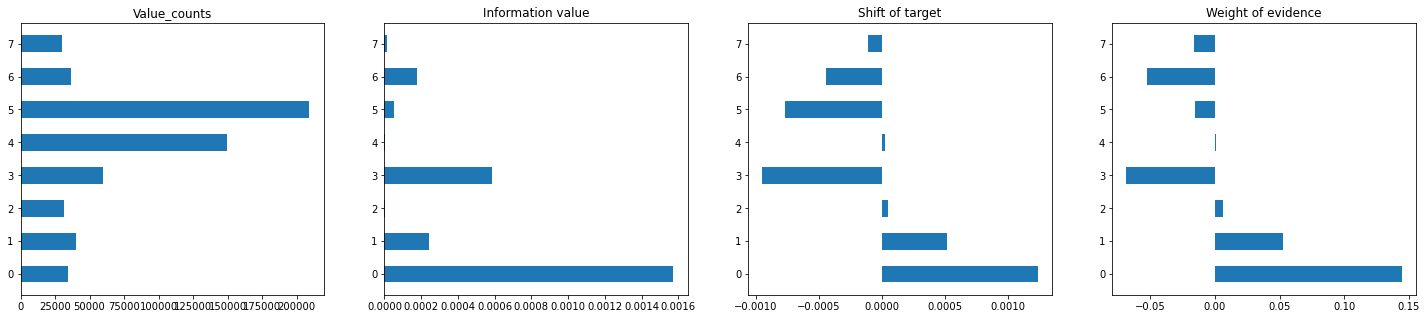



cred_enddate_month_bins005   IV score: 0.0010



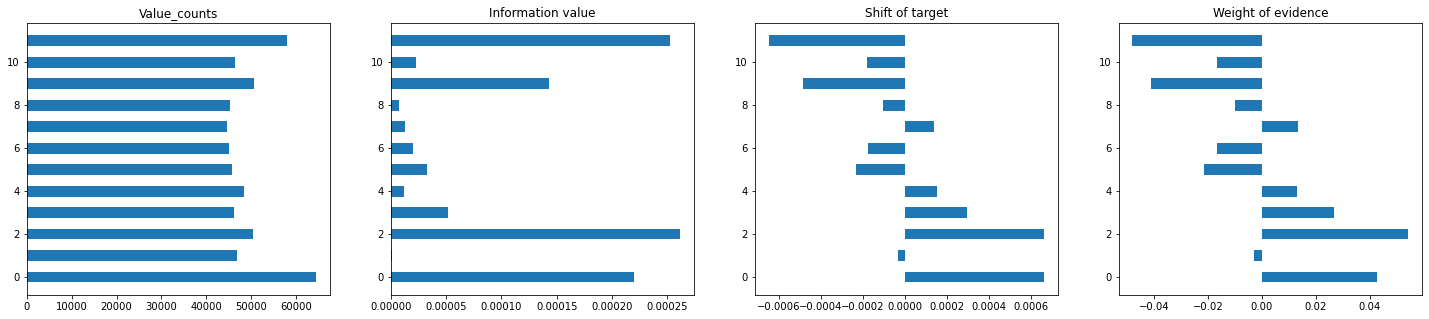



cred_enddate_day_bins005   IV score: 0.0006



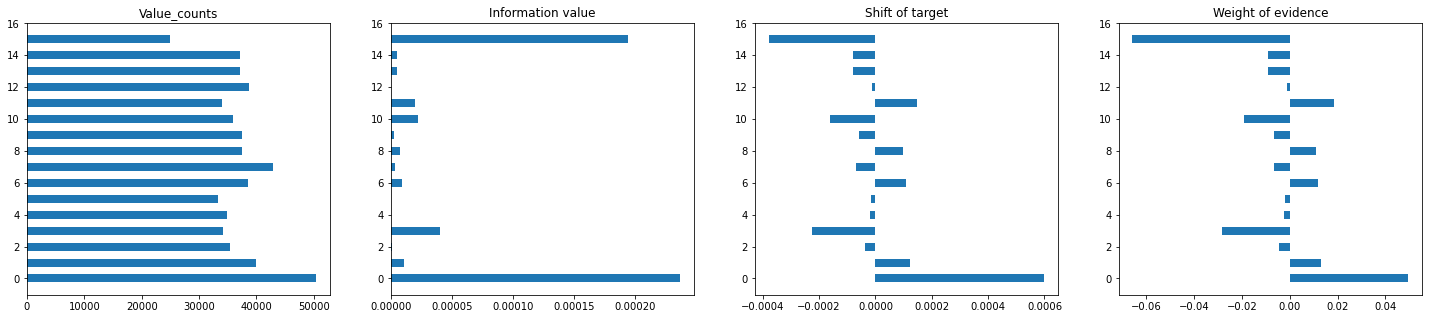



cred_date_payout_year_bins005   IV score: 0.0118



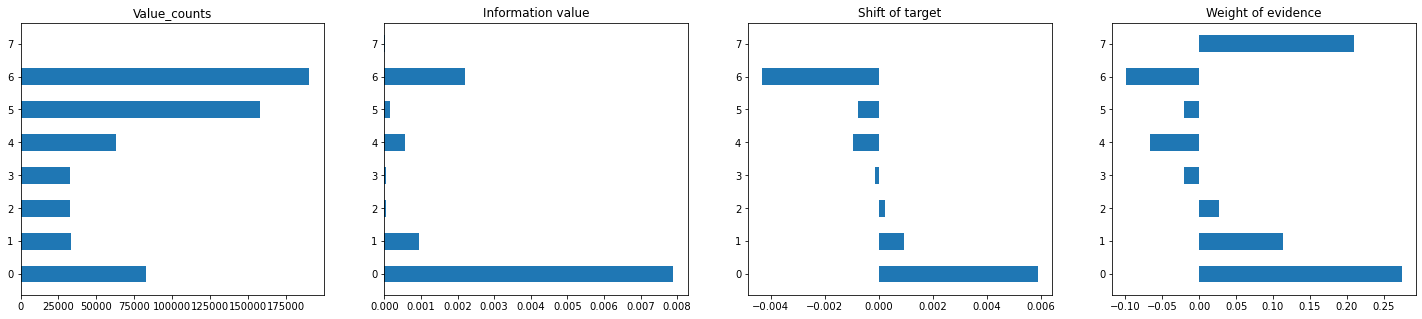



cred_date_payout_month_bins005   IV score: 0.0045



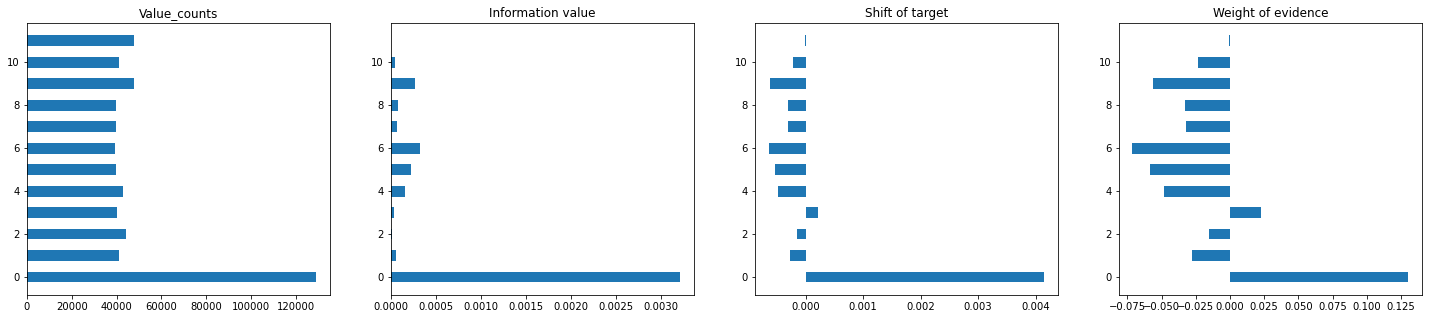



cred_date_payout_day_bins005   IV score: 0.0069



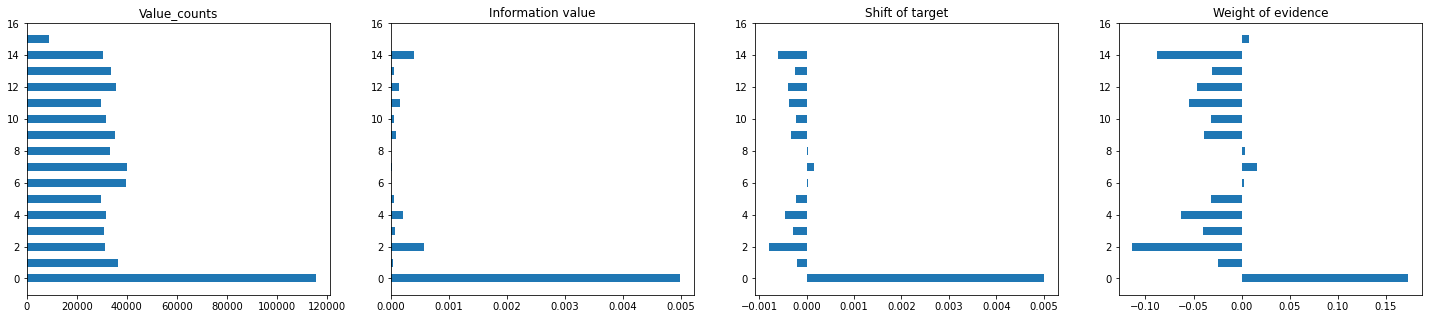



cred_date_percent_year_bins005   IV score: 0.0002



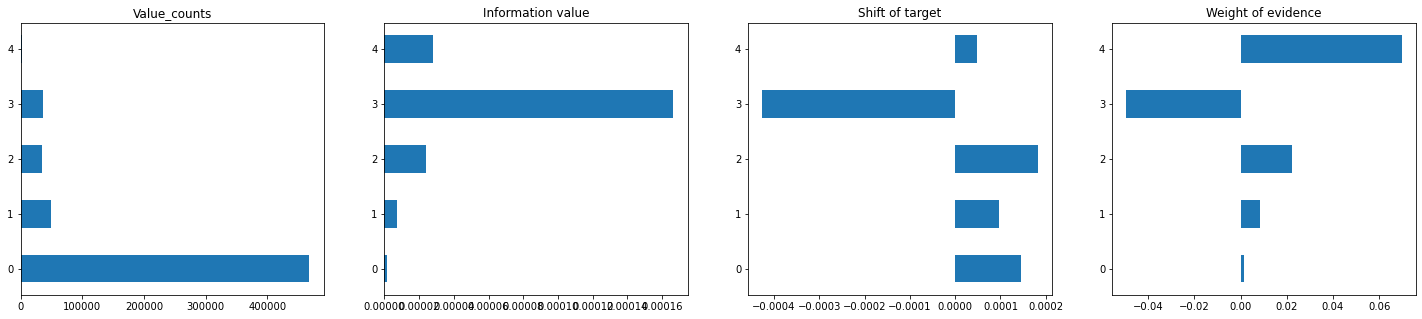



cred_date_percent_month_bins005   IV score: 0.0000



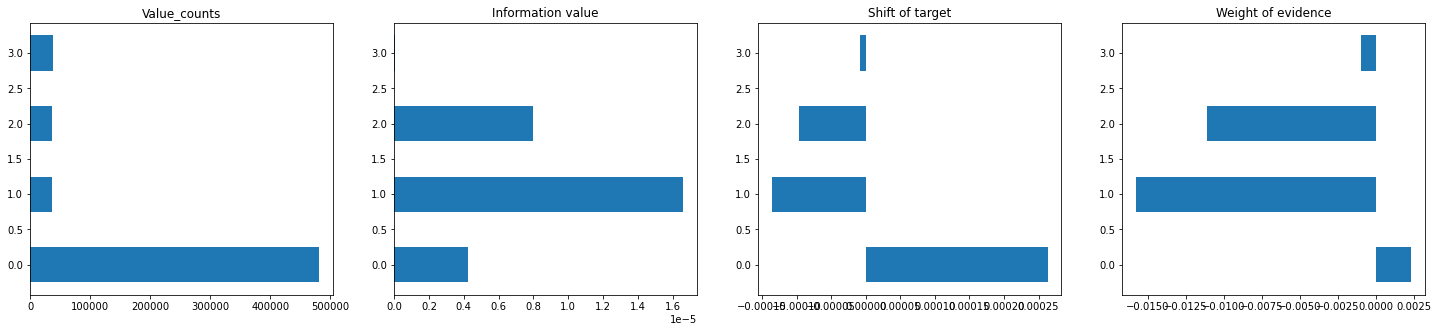



cred_date_percent_day_bins005   IV score: 0.0002



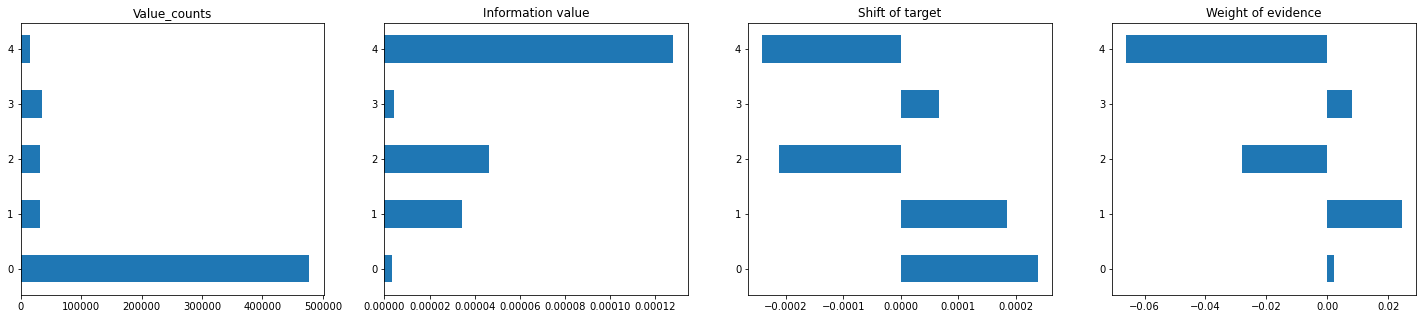



cred_active_date_year_bins005   IV score: 0.0018



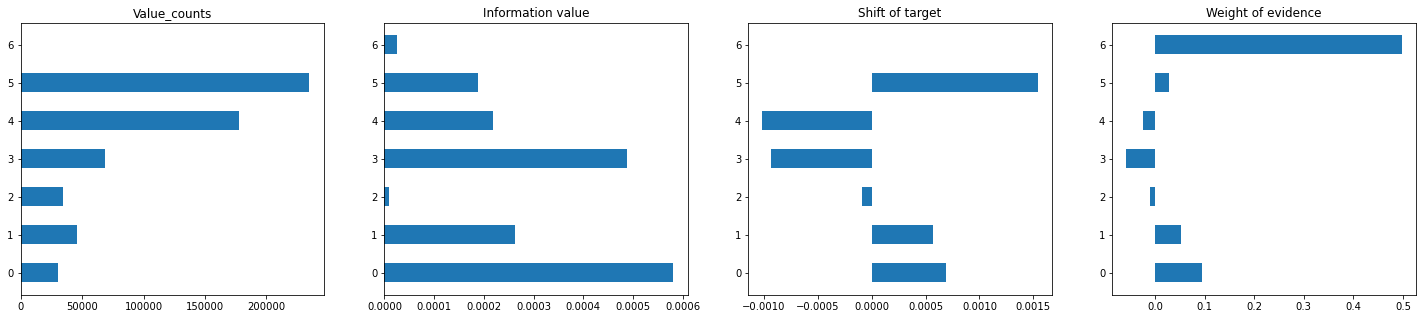



cred_active_date_month_bins005   IV score: 0.0013



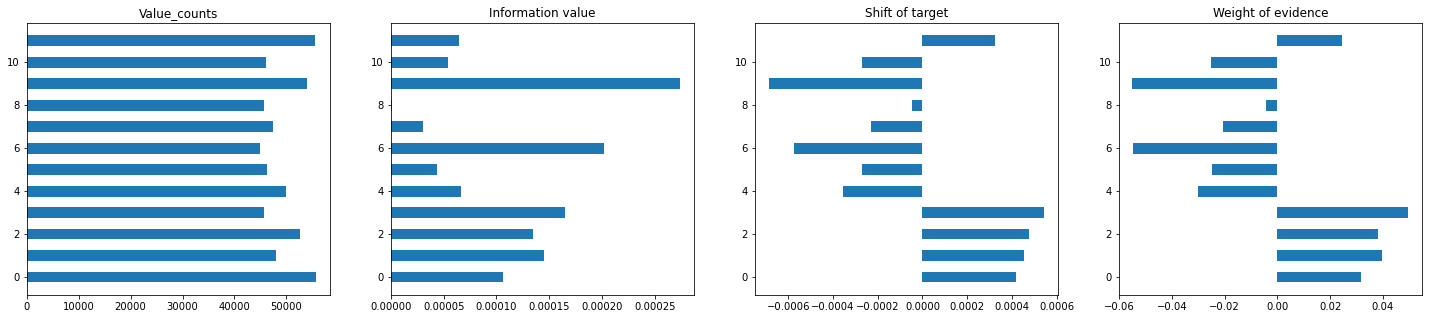



cred_active_date_day_bins005   IV score: 0.0011



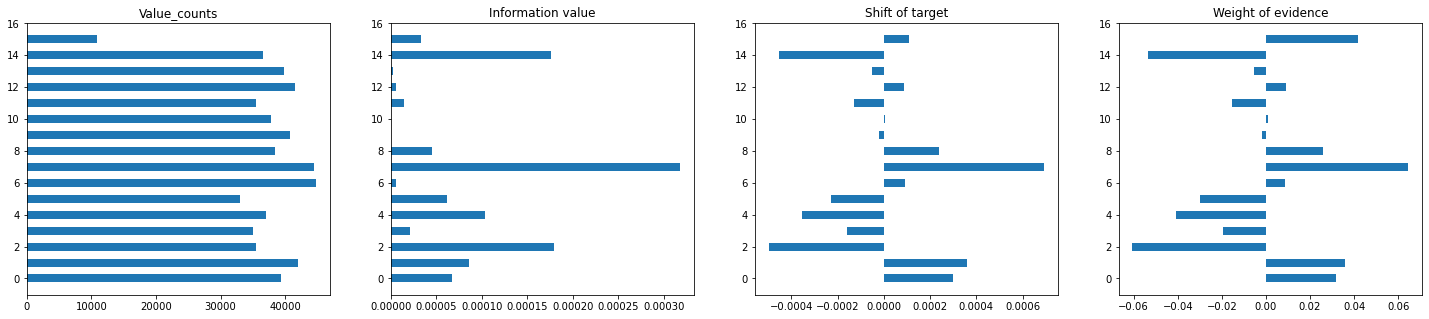

In [43]:
df, bin_dates_cols = col_by_bins(df, new_date_feats, 0.05)
print_barhs(df, bin_dates_cols, 'def_2')

Оставим cred_date_payout_year

# Формирование нового датасета

In [54]:
train_cat_feats = ['birthplace', 'cred_active', 'sector', ] + flags
train_num_feats = ['cred_date_payout_year'] + new_num_feats
train_feats = train_cat_feats + train_num_feats

In [55]:
train_cat_feats

['birthplace', 'cred_active', 'sector', 'request_amt_25000', 'income_400000']

In [56]:
train_num_feats

['cred_date_payout_year',
 'score',
 'income_edited_log',
 'request_amt_edited_log',
 'cred_max_overdue_log',
 'cred_sum_overdue_log',
 'cred_sum_payout_log',
 'op_cred_sum_paid_log',
 'ta_cred_sum_paid_log']

Сгруппируем клиентов с рассчётом их обязательств и признаков, которые мы отобрали.   
Будем использовать функцию count для cred_id  
Будем использовать функции mean, median, mode, std, min, max, sum для числовых значений  
Будем использовать функции mode, nunique для категориальных значений

In [67]:
df['cl_id'] = df['cl_id'].astype(int)

In [539]:
df2 = pd.DataFrame(index = np.unique(df['cl_id'].astype(int)))
df2 = pd.concat([df2, df.groupby(['cl_id'])['cred_id'].count().rename('cred_id_count')], axis = 1)
df2 = pd.concat([df2, df.groupby(['cl_id'])['def'].mean().rename('def')], axis = 1)

In [516]:
df2

cred_id_count  def
1                 13  1.0
2                 62  0.0
3                 22  0.0
4                307  0.0
5                 22  0.0
...              ...  ...
25611             34  1.0
25612            117  0.0
25613             18  0.0
25614             79  0.0
25615              7  0.0

[25615 rows x 2 columns]

In [540]:
df2_cat = pd.DataFrame(index = np.unique(df['cl_id'].astype(int)))
for col in train_cat_feats:
    df2_cat = pd.concat([df2_cat, df.groupby(['cl_id'])[col].apply(lambda x: x.mode()[0]).rename(col + '_mode')], axis = 1)
    df2_cat = pd.concat([df2_cat, df.groupby(['cl_id'])[col].nunique().rename(col + '_nunique')], axis = 1)

In [454]:
df2_cat

birthplace_mode  birthplace_nunique  \
1                                            СОСНОВЫЙБОР                   1   
2            ПОССВЕТЛЫЙ ДОБРОПОЛЬСКОГО Р-НА РЕСП УКРАИНА                   1   
3                                                    УФА                   1   
4                                                 РОССИЯ                   1   
5                                            НОВОКУЗНЕЦК                   1   
...                                                  ...                 ...   
25611                                           Г ЕРЕВАН                   1   
25612                                      ГОР ЛЕНИНГРАД                   1   
25613                                 КАЗАХСТАН ПАВЛОДАР                   1   
25614  ПОСКИРОВА ТРУНОВСКОГО РАЙОНА СТАВРОПОЛЬСКОГО КРАЯ                   1   
25615                                      ГОР ЛЕНИНГРАД                   1   

      cred_active_mode  cred_active_nunique sector_mode  sector_nunique  \
1                  0.0                    4           7               1   
2                  0.0                    6          16               1   
3                  0.0                    7           8               1   
4                  0.0                    4           3               1   
5                  0.0                    5          12               1   
...                ...                  ...         ...             ...   
25611              0.0                    3          16               1   
25612              0.0                    8          17               1   
25613              0.0                    4          16               1   
25614              0.0                    2          15               1   
25615              0.0                    2          17               1   

       request_amt_25000_mode  request_amt_25000_nunique  income_400000_mode  \
1                           0                          1                   0   
2                           0                          1                   0   
3                           0                          1                   0   
4                           0                          1                   0   
5                           0                          1                   0   
...                       ...                        ...                 ...   
25611                       0                          1                   0   
25612                       0                          1                   0   
25613                       0                          1                   0   
25614                       0                          1                   0   
25615                       0                          1                   0   

       income_400000_nunique  
1                          1  
2                          1  
3                          1  
4                          1  
5                          1  
...                      ...  
25611                      1  
25612                      1  
25613                      1  
25614                      1  
25615                      1  

[25615 rows x 10 columns]

In [541]:
df2_num = pd.DataFrame(index = np.unique(df['cl_id'].astype(int)))
for col in train_num_feats:
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].mean().rename(col + '_mean')], axis = 1)
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].median().rename(col + '_median')], axis = 1)
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].std().rename(col + '_std')], axis = 1)
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].min().rename(col + '_min')], axis = 1)
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].max().rename(col + '_max')], axis = 1)
    df2_num = pd.concat([df2_num, df.groupby(['cl_id'])[col].sum().rename(col + '_sum')], axis = 1)

In [362]:
df2_num

cred_date_payout_year_mean  cred_date_payout_year_median  \
1                     1962.153846                        2012.0   
2                     1995.645161                        2015.0   
3                     1990.500000                        2017.0   
4                     2013.377850                        2018.0   
5                     1982.818182                        2012.0   
...                           ...                           ...   
25611                 1991.058824                        2019.0   
25612                 2001.034188                        2019.0   
25613                 1992.222222                        2019.0   
25614                 2010.177215                        2019.0   
25615                 1983.142857                        2014.0   

       cred_date_payout_year_std  cred_date_payout_year_min  \
1                      59.908049                       1900   
2                      44.864494                       1900   
3                      50.272353                       1900   
4                      23.913390                       1900   
5                      51.954776                       1900   
...                          ...                        ...   
25611                  51.279354                       1900   
25612                  41.885915                       1900   
25613                  50.734088                       1900   
25614                  31.807014                       1900   
25615                  56.834346                       1900   

       cred_date_payout_year_max  cred_date_payout_year_sum  score_mean  \
1                           2018                      25508       485.0   
2                           2020                     123730       616.0   
3                           2020                      43791       496.0   
4                           2020                     618107       613.0   
5                           2019                      43622       525.0   
...                          ...                        ...         ...   
25611                       2020                      67696       570.0   
25612                       2020                     234121       534.0   
25613                       2020                      35860       606.0   
25614                       2020                     158804       634.0   
25615                       2020                      13882       640.0   

       score_median  score_std  score_min  ...  op_cred_sum_paid_log_std  \
1             485.0        0.0      485.0  ...                  4.676359   
2             616.0        0.0      616.0  ...                  2.841477   
3             496.0        0.0      496.0  ...                  3.193242   
4             613.0        0.0      613.0  ...                  2.092227   
5             525.0        0.0      525.0  ...                  3.884834   
...             ...        ...        ...  ...                       ...   
25611         570.0        0.0      570.0  ...                  3.606919   
25612         534.0        0.0      534.0  ...                  3.158495   
25613         606.0        0.0      606.0  ...                  3.712960   
25614         634.0        0.0      634.0  ...                  2.702716   
25615         640.0        0.0      640.0  ...                  5.717624   

       op_cred_sum_paid_log_min  op_cred_sum_paid_log_max  \
1                           0.0                 12.287426   
2                           0.0                 11.889245   
3                           0.0                 11.128174   
4                           0.0                 14.274073   
5                           0.0                 12.517888   
...                         ...                       ...   
25611                       0.0                 10.042945   
25612                       0.0                 14.150665   
25613                       0.0                 10.072694   
25614                

In [542]:
df2 = pd.concat([df2, df2_cat, df2_num], axis = 1)

# Разделение дата сета

In [520]:
df2.columns

Index(['cred_id_count', 'def', 'birthplace_mode', 'birthplace_nunique',
       'cred_active_mode', 'cred_active_nunique', 'sector_mode',
       'sector_nunique', 'request_amt_25000_mode', 'request_amt_25000_nunique',
       'income_400000_mode', 'income_400000_nunique',
       'cred_date_payout_year_mean', 'cred_date_payout_year_median',
       'cred_date_payout_year_std', 'cred_date_payout_year_min',
       'cred_date_payout_year_max', 'cred_date_payout_year_sum', 'score_mean',
       'score_median', 'score_std', 'score_min', 'score_max', 'score_sum',
       'income_edited_log_mean', 'income_edited_log_median',
       'income_edited_log_std', 'income_edited_log_min',
       'income_edited_log_max', 'income_edited_log_sum',
       'request_amt_edited_log_mean', 'request_amt_edited_log_median',
       'request_amt_edited_log_std', 'request_amt_edited_log_min',
       'request_amt_edited_log_max', 'request_amt_edited_log_sum',
       'cred_max_overdue_log_mean', 'cred_max_overdue_log_med

# Feature selection

In [522]:
df2['def'].value_counts()

0.0    20584
1.0     5031
Name: def, dtype: int64

In [543]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.fillna(df2.median()), 
    df2['def'], 
    test_size= 0.2, 
    # shuffle = True,
    stratify = df2['def'],
    random_state = 142
)

In [544]:
df2['def_2'] = np.NaN
df2.loc[X_train.index, 'def_2'] = df2.loc[X_train.index, 'def']

In [525]:
df2['def_2'].head(5)

1    1.0
2    NaN
3    0.0
4    NaN
5    NaN
Name: def_2, dtype: float64

In [526]:
df2['def_2'].tail(5)

25611    1.0
25612    0.0
25613    NaN
25614    0.0
25615    0.0
Name: def_2, dtype: float64

In [545]:
object_cols = df2.dtypes[df2.dtypes == 'object'].index

In [546]:
df2['birthplace_mode_vs'] = df2['birthplace_mode'].map(df2['birthplace_mode'].value_counts())


sector_mode_ordered_bins005   IV score: 0.0180



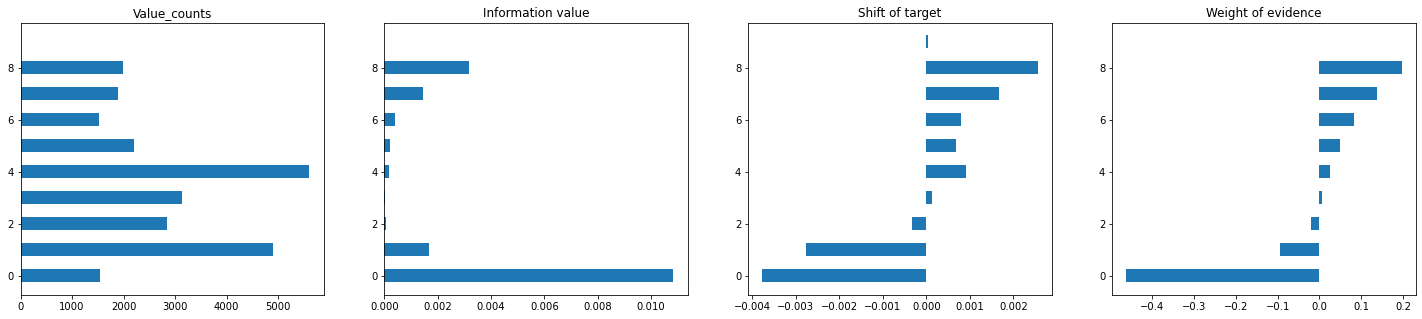



cred_active_mode_ordered_bins005   IV score: 0.0233



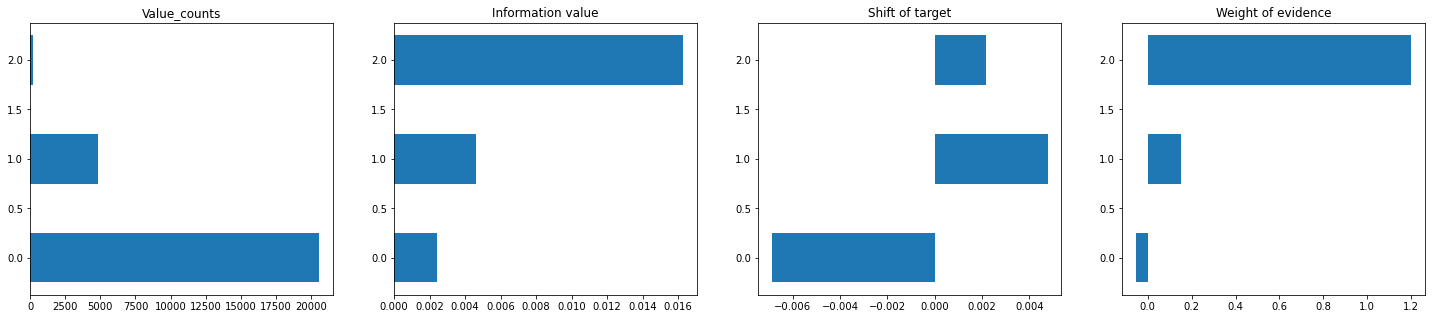

In [547]:
df2 = order_values(df2, ['sector_mode', 'cred_active_mode'], 'def_2', '_ordered').drop(object_cols, axis = 1)
df2, bin_cols = col_by_bins(df2, pd.Index(['sector_mode', 'cred_active_mode']) + '_ordered', 0.05)
print_barhs(df2, bin_cols, 'def_2')
# df2 = order_values(df2, bin_cols, 'def_2', '_ordered').drop(object_cols, axis = 1)

In [468]:
# df2.dtypes[df2.dtypes == 'object']

Series([], dtype: object)

In [429]:
# df2[pd.Index(bin_cols) + '_ordered'] = df2[pd.Index(bin_cols) + '_ordered'].astype(int)

In [548]:
features = df2.columns.drop(['def', 'def_2'])

In [549]:
X_train, X_test, y_train, y_test = train_test_split(
    df2[features].fillna(df2[features].median()), 
    df2['def'], 
    test_size= 0.2, 
    # shuffle = True,
    stratify = df2['def'],
    random_state = 142
)

In [550]:
random_state = 142

# доля отбрасываемых признаков
step = 0.1

# количество итераций
ps = range(0, 20)

# таблицы для сбора метрики на трейне и тесте
metric_fs_train = pd.DataFrame()
metric_fs_test = pd.DataFrame()

cv_splitter = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = random_state)

target = 'def'

In [551]:
X_train.isna().sum().sort_values(ascending = False).head(5)

cred_id_count                0
op_cred_sum_paid_log_mean    0
cred_max_overdue_log_max     0
cred_max_overdue_log_sum     0
cred_sum_overdue_log_mean    0
dtype: int64

In [552]:
cl = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    )

#алгоритмы для отбора фичей встроенным методом

lg_gain = LGBMClassifier(
    n_jobs = -1,
    random_state=random_state,
    importance_type = 'gain',
    )

rf = RandomForestClassifier(
    n_jobs = -1, 
    random_state=random_state,
    )

log = LogisticRegression(
    random_state=random_state,
    solver = 'liblinear',
    penalty = 'l1'
    )

In [ ]:
lgbm_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, cl, X_train, y_train, X_train.index, step, 
    ps, features, cv_splitter, metric_fs_train, 
    metric_fs_test, 'roc_auc', 'lgbm'
    )

lgbm_gain_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, lg_gain, X_train, y_train, X_train.index,
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'roc_auc', 'lgbm_gain'
    )

rf_feats, metric_fs_train, metric_fs_test = cl_fs(
    cl, rf, X_train, y_train, X_train.index,
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'roc_auc', 'rf'
    )

L1_feats, metric_fs_train, metric_fs_test = L1_fs(
    cl, log, X_train, y_train, X_train.index,
    step, ps, features, cv_splitter, 
    metric_fs_train, metric_fs_test, 'roc_auc', 'log'
    )

In [555]:
metric_fs_test.iloc[np.where(metric_fs_test == metric_fs_test.max().max())]

8
log  0.697757

In [556]:
metric_fs_test

0         1         2         3         4         5  \
lgbm       0.695029  0.695045  0.695036  0.694056  0.695209  0.694261   
lgbm_gain  0.695021  0.695040  0.695033  0.694060  0.694685  0.694793   
rf         0.695105  0.694943  0.695349  0.695014  0.693691  0.692118   
log        0.695316  0.694381  0.696058  0.695366  0.696384  0.695696   

                  6         7         8         9        10        11  \
lgbm       0.695523  0.695125  0.695385  0.693847  0.693321  0.692647   
lgbm_gain  0.695150  0.694871  0.693598  0.693149  0.692719  0.693392   
rf         0.692929  0.692264  0.688689  0.689190  0.689241  0.689359   
log        0.695100  0.696302  0.697757  0.697148  0.695242  0.696274   

                 12        13        14        15        16        17  \
lgbm       0.688911  0.689805  0.689266  0.689875  0.688779  0.689167   
lgbm_gain  0.692197  0.692813  0.692480  0.692209  0.691288  0.693277   
rf         0.689373  0.679577  0.678680  0.677903  0.678130  0.678626   
log        0.692975  0.692055  0.692795  0.693231  0.692740  0.694572   

                 18        19  
lgbm       0.689631  0.689115  
lgbm_gain  0.689980  0.688759  
rf         0.678312  0.679399  
log        0.691236  0.691175

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

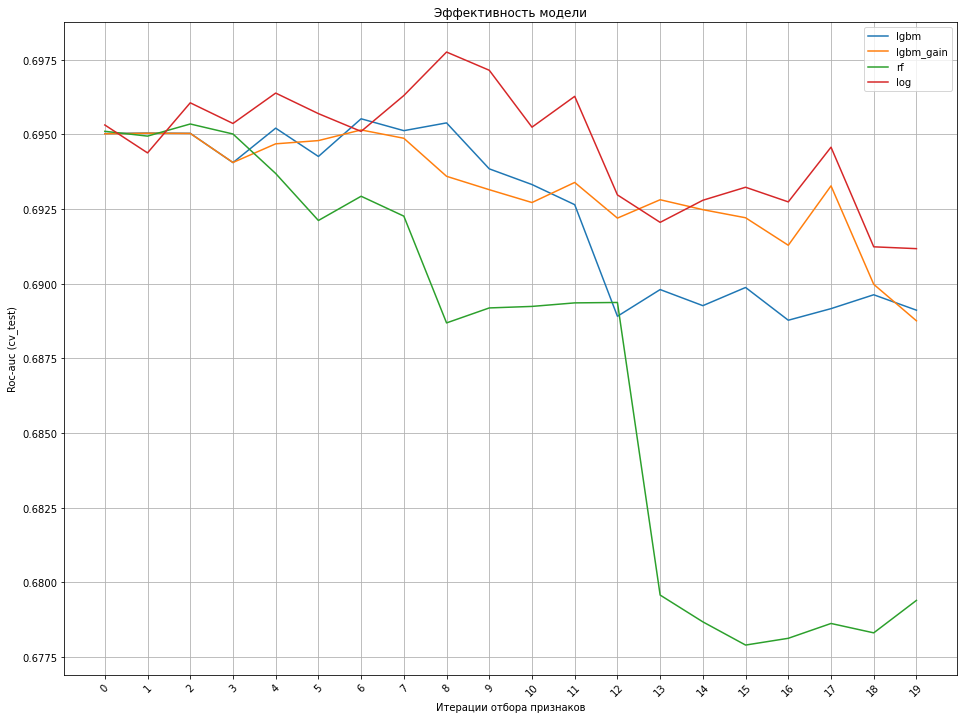

In [557]:
fig, ax = plt.subplots(figsize=(16, 12))
for i in metric_fs_test.index:
    ax.plot(metric_fs_test.columns, metric_fs_test.loc[i, :], label=i)
ax.legend()
plt.title("Эффективность модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('Roc-auc (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_test.columns, rotation = 45)
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

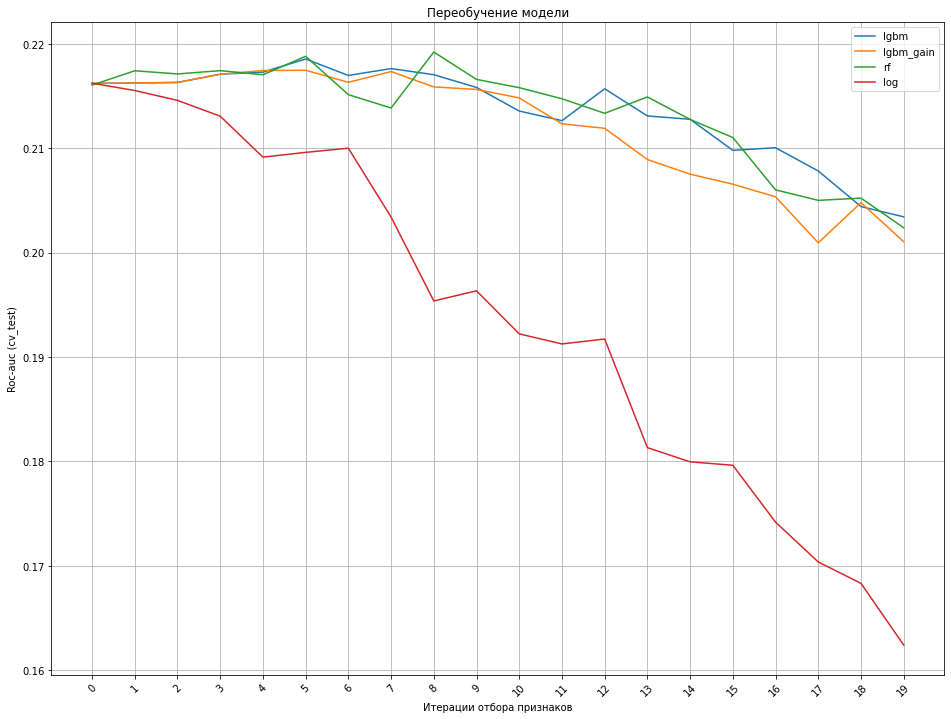

In [558]:
fig, ax = plt.subplots(figsize=(16, 12))
metric_fs_diff = metric_fs_train - metric_fs_test
for i in metric_fs_test.index:
    ax.plot(metric_fs_diff.columns, metric_fs_diff.loc[i, :], label=i)
ax.legend()
plt.title("Переобучение модели")
ax.set_xlabel('Итерации отбора признаков')
ax.set_ylabel('Roc-auc (cv_test)')
ax.grid(True)
plt.xticks(metric_fs_diff.columns, rotation = 45)
plt.show()

In [559]:
new_feats = L1_feats[8]
new_feats

['cred_date_payout_year_median',
 'ta_cred_sum_paid_log_max',
 'cred_max_overdue_log_min',
 'cred_sum_overdue_log_sum',
 'request_amt_edited_log_mean',
 'sector_mode_ordered',
 'ta_cred_sum_paid_log_min',
 'op_cred_sum_paid_log_mean',
 'cred_sum_overdue_log_max',
 'cred_max_overdue_log_std',
 'cred_sum_payout_log_min',
 'cred_id_count',
 'score_median',
 'cred_active_mode_ordered',
 'cred_sum_payout_log_mean',
 'cred_date_payout_year_min',
 'request_amt_edited_log_median',
 'cred_date_payout_year_mean',
 'cred_active_mode_ordered_bins005',
 'income_edited_log_median',
 'ta_cred_sum_paid_log_mean',
 'income_edited_log_sum',
 'cred_date_payout_year_sum',
 'score_max',
 'score_sum',
 'request_amt_edited_log_sum',
 'cred_sum_payout_log_sum',
 'ta_cred_sum_paid_log_sum']

In [560]:
metric_table = pd.DataFrame()

i = 0
for max_depth in [2, 3, 4, 5, 6, 7, 8, -1]:
    for num_leaves in [10, 24, 31, 37]:
                    cl = LGBMClassifier(
                        n_jobs = -1, 
                        max_depth = max_depth,
                        random_state = random_state,
                        num_leaves = num_leaves,
                        )
            
                    cv_res = cross_validate(
                        cl, X_train[new_feats], 
                        y_train, 
                        scoring= 'roc_auc', 
                        n_jobs = -1, 
                        cv = cv_splitter, 
                        return_train_score = True,
                         verbose = 0
                         )
                         
                    metric_table.loc[i, 'max_depth'] = max_depth
                    metric_table.loc[i, 'num_leaves'] = num_leaves
                    
                    metric_table.loc[i, 'cv_train'] = cv_res['train_score'].mean()
                    metric_table.loc[i, 'cv_test'] = cv_res['test_score'].mean()

                    # print (i)

                    i+= 1
            
metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']
metric_table = metric_table.sort_values(by = 'cv_test', ascending = False)
metric_table.head(10)

max_depth  num_leaves  cv_train   cv_test    cv_dif
4         3.0        10.0  0.752515  0.708201  0.044313
5         3.0        24.0  0.752515  0.708201  0.044313
6         3.0        31.0  0.752515  0.708201  0.044313
7         3.0        37.0  0.752515  0.708201  0.044313
0         2.0        10.0  0.728280  0.707627  0.020653
1         2.0        24.0  0.728280  0.707627  0.020653
2         2.0        31.0  0.728280  0.707627  0.020653
3         2.0        37.0  0.728280  0.707627  0.020653
20        7.0        10.0  0.778721  0.706558  0.072163
8         4.0        10.0  0.770180  0.706320  0.063860

Наш результат на кросс - валидации = 0.708

# Predict

При большом количестве признаков во время этапа отбора признаков, с моей точки зрения, было бы целесообразно использовать  
LightGBMClassifier, т.к. он работает шустрее и имеет возможность параллелить часть процессов (параметр n_jobs).  
Но у нас немного признаков, поэтому под наши задачи подойдёт CatBoostClassifier, к тому же, нашим основным признаком будет категориальный 'defaulted'.  
Остальные взаимоcвязи категориальных признаков CatBoost постарается найти сам, поэтому нам нет необходимости делать дополнительную предобработку категориальных признаков.  
Ускорим его работу с помощью параметра task_type='GPU'  
Проведём 4 фолдовую стратифицированную кросс-валидацию.  
Т.к. мы отказались от идеи временных рядов, то и TimeSeriesSplitter нам не понадобится

Разделим выборку на Трен и Тест (последние 20% датасета, shuffle = False).  
На Трейне проведём кросс валидацию

In [561]:
X_train, X_test, y_train, y_test = train_test_split(
    df2[new_feats].fillna(df2[new_feats].median()), 
    df2['def'], 
    test_size= 0.2, 
    # shuffle = True,
    stratify = df2['def'],
    random_state = 142
)

In [562]:
lgbm = LGBMClassifier(
    random_state = random_state,
    n_jobs = -1,
    max_depth = 3
)

lgbm.fit(X_train, y_train)
predict_proba = lgbm.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, predict_proba)

In [563]:
# наша итоговая метрика Roc-Auc на тестовой части
score

0.7131891671588154

Итоговая метрика чуть лучше метрики на кросс-валидации.

(array([1109., 1542., 1285.,  669.,  299.,  143.,   52.,   14.,    6.,
           4.]),
 array([0.00997369, 0.097193  , 0.18441231, 0.27163162, 0.35885093,
        0.44607024, 0.53328955, 0.62050886, 0.70772817, 0.79494748,
        0.88216679]),
 <BarContainer object of 10 artists>)

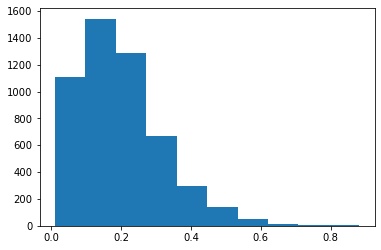

In [564]:
# распределение вероятностей предсказаания
plt.hist(predict_proba)

In [565]:
# Важность признаков для модели

imp = pd.Series(data = lgbm.feature_importances_, index = new_feats).sort_values(ascending = False)
imp

score_median                        103
request_amt_edited_log_mean          95
ta_cred_sum_paid_log_mean            49
ta_cred_sum_paid_log_max             45
cred_sum_overdue_log_sum             34
income_edited_log_median             32
op_cred_sum_paid_log_mean            31
sector_mode_ordered                  30
cred_max_overdue_log_std             29
cred_sum_payout_log_sum              27
cred_sum_overdue_log_max             26
cred_date_payout_year_mean           25
cred_date_payout_year_median         24
ta_cred_sum_paid_log_sum             22
cred_sum_payout_log_mean             21
cred_max_overdue_log_min             20
score_sum                            12
cred_active_mode_ordered             11
income_edited_log_sum                10
request_amt_edited_log_sum            8
cred_id_count                         5
cred_sum_payout_log_min               5
cred_date_payout_year_sum             5
ta_cred_sum_paid_log_min              3
cred_date_payout_year_min             1


# Итоги и рекомендации

Что сделано:
1. Смоделировали задачу вероятностной классификации.
2. Разделили датасет на валидационную и итоговую тестовую часть.
3. Выбрали метрику для оценки качества работы модели - Roc-Auc.
4. Предприняли меры, чтобы избежать ликов в тестовую часть. 
5. Провели EDA, увидели особенности датасета, преобразовали признаки, оценили важность, избавились от выбросов
6. Сформировали новые признаки, провели отбор признаков.
8. Провели кросс-валидацию и неглубокий побор гиперпараметров: Roc-Auc = 0.708
9. Сделали предикт на тестовую часть: Roc-Auc = 0.713
10. Выделили важные признаки:
- Самые важные признаки: 'score_median', 'request_amt_edited_log_mean'

Возможности повышения эффективности модели:  
1. Увеличить количество данных.
2. Обогатить существующие данные новыми признаками.  
3. Сгенерировать новые признаки:
- провести дополнительный EDA, найти зависимости, сгенирировать признаки
- сгенерировать признаки при помощи математических преобразований
4. Выбрать другой алгоритм бустинга, например CatBoost или XGboost, составить композицию из алгоритмов
5. Провести более глубокий подбор гиперпараметров
6. Попробовать оптимизировать эффективность, используя другие метрики: f1-score, prescision, recall, brier_score  